# Notebook: Analyses for merged dataset 1

#### The dataset analyzed includes data from SteamDB and Game_Data.
#### The analyses are the same as in analyses_nlp_comparison, but it also uses data about player count and reviews on Steam.

## Structure of notebook
#### Step 1: Imports, functions and classes
#### Step 2: Data preparation
#### Step 3: NLP basics
#### Step 4a: Vectorization, analysis and basic plots (using selected controls)
#### Step 4b: Printing and plotting most influential words (using selected controls)
#### Step 5a: Vectorization, analysis and basic plots (using extended controls)
#### Step 5b: Printing and plotting most influential words (using extended controls)


## Step 1: Imports, functions and classes

In [1]:

####################################
## Requirements: spacy, en_core_web_sm, nltk stopwords
####################################

## General imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## Imports for NLP
import nltk, re, spacy, string
from spacy.lang.en.examples import sentences
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## Imports for analyses
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

## Imports from analyses_tools (local)
from analyses_tools import oh_encoder, NLPAnalyzer


## Function for data preparation

def data_preparation(df):
    """Take a dataframe, prepare it for use in NLP and analyses and return prepared dataframe.
    
    Args:
        df (Dataframe): Original dataframe to be prepared
        
    Returns:
        df (Dataframe): Prepared dataframe
        
    """

    df = df.copy()
    
    ###############################    
    ## Data Cleaning & Recoding
    ###############################
    
    ## drop columns not used in analyses
    df.drop(['sid', 'store_promo_url', 'published_meta', 'published_stsp', 'published_hltb',
             'published_igdb', 'image', 'current_price', 'discount', 
             'gfq_url', 'gfq_difficulty_comment', 'gfq_rating_comment', 'gfq_length_comment',
             'hltb_url', 'meta_url', 'igdb_url', 'Unnamed: 0', 'game', 'steam_url', 'release', 
             'positive_reviews', 'negative_reviews', 'primary_genre', 'store_genres', 
             'publisher', 'developer', 'detected_technologies', 'store_asset_mod_time', 
             'players_right_now', '24_hour_peak', 'all_time_peak', 'all_time_peak_date'], 
            axis=1, inplace=True)

    ## publish date as timedelta
    df["published_store"] = pd.to_datetime(df["published_store"]) - pd.Timestamp(1997, 1, 1)
    df["published_store"] = df["published_store"].apply(lambda value: value.days)
     
    ## missing data 1: If language or voiceover is missing, set to "One_unknown"
    df.loc[df["languages"].isna(), "languages"] = "One_unknown"
    df.loc[df["voiceovers"].isna(), "voiceovers"] = "One_unknown"

    ## delete games without English as language:
    count_no_en = 0
    for x in df.index:
        if "english" not in df.loc[x,"languages"].lower():
            count_no_en += 1
            df = df.drop(labels=x, axis=0)
    print(f"Games without English language: {count_no_en}")
             
    ## use only number of languages and voiceovers
    df["languages"] = df["languages"].apply(lambda value: len(value.split(",")))
    df["voiceovers"] = df["voiceovers"].apply(lambda value: len(value.split(",")))
      
    ## missing data 2: drop columns with more than 75% missing data:
    for col in df.columns:
        if df[col].isna().sum() > df.shape[0]*0.75:
            df.drop(col, axis=1, inplace=True) 
    
    ## One-Hot-Encoding
    
    ## Genres
    ## split strings in genre and platform columns
    df['genres'] = df['genres'].apply(lambda x: x.split(','))
    df['platforms'] = df['platforms'].apply(lambda x: x.split(','))
    ## replace genres
    df['genres'] = df['genres'].apply(lambda genres: list(set(['Indie' if genre == 'Инди' else genre for genre in genres])))
    df['genres'] = df['genres'].apply(lambda genres: list(set(['Adventure' if genre == 'Приключенческие игры' else genre for genre in genres])))
    
    ## One-Hot Encoding
    df = oh_encoder(df, "genres")
    df = oh_encoder(df, "platforms")
    
    ## Rename columns including spaces
    df.rename(columns={'Game Development':'Game_Development',
                      'Free to Play':'Free_to_Play',
                      'Massively Multiplayer':'Massively_Multiplayer',
                      'Early Access':'Early_Access',
                      'Sexual Content':'Sexual_Content'}, inplace=True)

    return df


## Function for text cleaning

def text_cleaner(sentence):
    """Take a string, clean it for use in vectorization and return cleaned string.
    
    Args:
        sentence (string): Original string to be cleaned
        
    Returns:
        doc_str (string): Cleaned String
        
    """
    
    ## counter
    global call_count 
    call_count += 1
    if call_count%1000 == 0:
        print(call_count)
    if sentence is None:
        doc_str = ""
    else:
        ## delete html tags
        sentence = re.sub("<.*?>", "", sentence)
        
        ## tokenize and delete pronouns, stopwords and punctuation
        doc = nlp(sentence)
        clean_doc = [token.lemma_.lower() for token in doc if (token.pos_ !="PRON") and (token.lemma_ not in stopWords) and (token.lemma_ not in punctuations)]
        ## rejoin texts
        doc_str = " ".join(clean_doc)
        ## deleting points, tabs, spaces and line breaks
        doc_str = re.sub("[\s]+", " ", doc_str)
        ## deleting numbers
        doc_str = re.sub(r'\d+', '', doc_str) 
    return doc_str



## Adjusting display
pd.set_option('display.max_rows', 100) # display more rows
pd.set_option('display.max_columns', 50) # display more columns
pd.set_option('display.float_format', '{:.2f}'.format) # display numbers as decimals

## Step 2: Data preparation

In [2]:
## load merged data 
df = pd.read_pickle("../../data/df_merge1.pkl", compression='bz2')

display(df.describe().T)
display(df.dtypes)

## Prepare data
df = data_preparation(df)

display(df.describe().T)
display(df.dtypes)


,count,mean,std,min,25%,50%,75%,max
sid,52560.00,959760.86,464752.18,360.00,580002.50,936775.00,1312745.00,1979280.00
store_uscore,33350.00,70.26,19.76,1.00,56.00,75.00,86.00,100.00
full_price,45460.00,905.36,1078.57,50.00,299.00,599.00,1099.00,99900.00
current_price,45460.00,845.68,1047.00,49.00,299.00,499.00,999.00,99900.00
discount,6465.00,45.38,22.13,5.00,25.00,50.00,60.00,90.00
achievements,28516.00,48.07,294.82,1.00,10.00,19.00,34.00,9821.00
gfq_rating,13179.00,3.33,0.87,0.50,3.00,3.50,3.92,5.00
gfq_length,10368.00,17.34,19.15,0.50,4.90,10.00,20.00,80.00
stsp_owners,34590.00,116211.04,1404864.69,10000.00,10000.00,10000.00,35000.00,150000000.00
stsp_mdntime,9024.00,435.95,2238.28,1.00,71.00,205.00,342.00,137570.00


sid                         int64
steam_url                  object
store_promo_url            object
store_uscore              float64
published_store            object
published_meta             object
published_stsp             object
published_hltb             object
published_igdb             object
image                      object
name                       object
description                object
full_price                float64
current_price             float64
discount                  float64
platforms                  object
developers                 object
publishers                 object
languages                  object
voiceovers                 object
categories                 object
genres                     object
tags                       object
achievements              float64
gfq_url                    object
gfq_difficulty             object
gfq_difficulty_comment     object
gfq_rating                float64
gfq_rating_comment         object
gfq_length    

Games without English language: 1819


,count,mean,std,min,25%,50%,75%,max
store_uscore,32505.00,70.20,19.74,1.00,56.00,75.00,86.00,100.00
published_store,50656.00,7978.41,914.85,2632.00,7496.00,8101.00,8681.00,9247.00
full_price,44049.00,905.43,1071.89,50.00,299.00,599.00,1099.00,99900.00
languages,50741.00,3.49,5.01,1.00,1.00,1.00,4.00,29.00
voiceovers,50741.00,1.48,2.80,1.00,1.00,1.00,1.00,29.00
achievements,27948.00,48.55,297.76,1.00,10.00,19.00,34.00,9821.00
gfq_rating,13123.00,3.33,0.87,0.50,3.00,3.50,3.92,5.00
stsp_owners,33703.00,118538.56,1422992.13,10000.00,10000.00,10000.00,35000.00,150000000.00
hltb_single,14419.00,8.55,56.97,1.00,1.00,4.00,9.00,5149.00
igdb_popularity,20565.00,2.65,14.59,1.00,1.00,1.00,1.45,997.77


store_uscore             float64
published_store          float64
name                      object
description               object
full_price               float64
developers                object
publishers                object
languages                  int64
voiceovers                 int64
categories                object
tags                      object
achievements             float64
gfq_rating               float64
stsp_owners              float64
hltb_single              float64
igdb_popularity          float64
peak_players               int64
total_reviews              int64
rating                   float64
review_percentage        float64
Strategy                 float64
Indie                    float64
Movie                    float64
Early_Access             float64
Adventure                float64
Sports                   float64
Free_to_Play             float64
Casual                   float64
Simulation               float64
Action                   float64
Nudity    

## Step 3: NLP basics

In [3]:

## load language model
nlp = spacy.load("en_core_web_sm")

#########################################
## Users might need to manually download stopwords:
# nltk.download('stopwords')
#########################################

## Clean "description"
stopWords = stopwords.words("english")
punctuations = string.punctuation

## Applying text_cleaner to description
print("*"*50 + "\nStarting text cleaner\n" + "*"*50) 
## Adding a global counter to print in text_cleaner function since it takes a long time
call_count = 0
## Using text_cleaner
df["description_clean_nonum"] = df["description"].apply(text_cleaner)



**************************************************
Starting text cleaner
**************************************************
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


In [4]:
#########################################
## optional: save as pickle for fast reload
# df.to_pickle("../../data/df_merged_1_with_lemmas_compressed.pkl", compression='bz2')
#########################################

## Step 4a: Vectorization, analysis and basic plots (using selected controls)

In [5]:
#########################################
## optional: if saved as pickle, load it here:
# df = pd.read_pickle("../../data/df_merged_1_with_lemmas_compressed.pkl", compression='bz2')
#########################################

************************************************** 
 Initialization - Target: stsp_owners 
 **************************************************
************************************************** 
 Data preparation done 
 **************************************************
Scaling the following columns for analyses: ['published_store', 'full_price', 'languages', 'voiceovers', 'review_percentage']
************************************************** 
 NLP: 0 words - Vectorization done 
 **************************************************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            stsp_owners   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     65.56
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          1.15e-315
Time:                        23:08:04   Log-Likelihood:            -2.5022e+05
No. Observations:               17118   AIC:                         5.005e+05
Df Residuals:                   17092   BIC:                         5.007e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.881e+04   3.13e+05      0.060      0.952   -5.94e+05    6.31e+05
published_store       -1.096e+05   4375.204    -25.053      0.000   -1.18e+05   -1.01e+05
full_price             7.301e+04   4204.762     17.364      0.000    6.48e+04    8.13e+04
languages              7.264e+04   4971.619     14.610      0.000    6.29e+04    8.24e+04
voiceovers            -2899.5135   4918.345     -0.590      0.556   -1.25e+04    6740.947
review_percentage      4.291e+04   4175.274     10.277      0.000    3.47e+04    5.11e+04
Strategy               3424.2580   1.08e+04      0.316      0.752   -1.78e+04    2.47e+04
Indie                 -2.407e+04   9709.786     -2.479      0.013   -4.31e+04   -5035.171
Movie                  2.175e-11   1.68e-10      0.130      0.897   -3.07e-10     3.5e-10
Early_Access          -1.045e+04   1.37e+04     -0.763      0.445   -3.73e+04    1.64e+04
Adventure             -1.316e+04   8923.817     -1.475      0.140   -3.07e+04    4326.641
Sports                 -1.09e+04      2e+04     -0.544      0.586   -5.02e+04    2.84e+04
Free_to_Play            348.8668   1.74e+04      0.020      0.984   -3.38e+04    3.45e+04
Casual                -2.336e+04   8927.166     -2.617      0.009   -4.09e+04   -5862.054
Simulation             1.092e+04    1.1e+04      0.992      0.321   -1.07e+04    3.25e+04
Action                 3.155e+04   8780.230      3.594      0.000    1.43e+04    4.88e+04
Nudity                  -1.3e+04   7.76e+04     -0.168      0.867   -1.65e+05    1.39e+05
RPG                    1173.6761   1.15e+04      0.102      0.919   -2.14e+04    2.38e+04
Violent               -1.179e+04   4.55e+04     -0.259      0.796   -1.01e+05    7.74e+04
Sexual_Content        -1.348e+04   7.89e+04     -0.171      0.864   -1.68e+05    1.41e+05
Game_Development       9055.8006    5.4e+05      0.017      0.987   -1.05e+06    1.07e+06
Massively_Multiplayer -3.032e+04   2.64e+04     -1.147      0.251   -8.21e+04    2.15e+04
Gore                  -1.973e+04   5.48e+04     -0.360      0.719   -1.27e+05    8.77e+04
Racing                -3.125e+04   2.19e+04     -1.424      0.155   -7.43e+04    1.18e+04
WIN                    9.602e+04   3.12e+05      0.307      0.759   -5.16e+05    7.08e+05
LNX                    3.865e+04   1.32e+04      2.919      0.004    1.27e+04    6.46e+04
MAC                    1458.4956   1.15e+04      0.127      0.899   -2.11e+04     2.4e+04
==============================================================================
Omnibus:                    41857.704   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1021201869.300
Skew:                          25.610   Prob(JB):                         0.00
Kurtosis:                    1198.464   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.08750244057523093
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.08616775540172184
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.024056625905294893
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.01941664155936118
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.024056625905294893 0.01958927947457967
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
0.02307931035107791 0.018607490292825823
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.01928905438951789 0.0147998845680

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           store_uscore   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     22.53
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          2.22e-105
Time:                        23:12:15   Log-Likelihood:                -93260.
No. Observations:               21193   AIC:                         1.866e+05
Df Residuals:                   21166   BIC:                         1.868e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    81.0608     11.405      7.108      0.000      58.707     103.415
published_store          -0.4341      0.143     -3.040      0.002      -0.714      -0.154
full_price                1.8300      0.137     13.326      0.000       1.561       2.099
languages                 2.2193      0.161     13.760      0.000       1.903       2.535
voiceovers               -0.3666      0.160     -2.297      0.022      -0.679      -0.054
total_reviews             0.6059      0.137      4.419      0.000       0.337       0.875
Strategy                 -0.0275      0.357     -0.077      0.939      -0.726       0.672
Indie                    -0.8858      0.323     -2.744      0.006      -1.519      -0.253
Movie                    25.0494     19.757      1.268      0.205     -13.676      63.774
Early_Access              1.1302      0.443      2.550      0.011       0.262       1.999
Adventure                 0.5072      0.292      1.738      0.082      -0.065       1.079
Sports                   -0.1526      0.659     -0.232      0.817      -1.444       1.138
Free_to_Play              0.7177      0.557      1.288      0.198      -0.374       1.810
Casual                   -0.5180      0.290     -1.783      0.075      -1.087       0.051
Simulation               -0.7077      0.361     -1.963      0.050      -1.414      -0.001
Action                    0.1458      0.289      0.505      0.614      -0.420       0.712
Nudity                   -1.2487      2.339     -0.534      0.593      -5.833       3.335
RPG                       0.2193      0.381      0.575      0.565      -0.528       0.967
Violent                  -2.9992      1.316     -2.279      0.023      -5.578      -0.420
Sexual_Content           -2.8337      2.474     -1.145      0.252      -7.684       2.016
Game_Development         18.3913     19.742      0.932      0.352     -20.304      57.086
Massively_Multiplayer    -1.5946      0.856     -1.862      0.063      -3.273       0.084
Gore                      1.5388      1.644      0.936      0.349      -1.684       4.762
Racing                    1.4368      0.731      1.965      0.049       0.003       2.870
WIN                     -10.4617     11.400     -0.918      0.359     -32.806      11.883
LNX                       0.0623      0.439      0.142      0.887      -0.798       0.923
MAC                       0.5706      0.380      1.503      0.133      -0.174       1.315
==============================================================================
Omnibus:                     1747.103   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2212.039
Skew:                          -0.786   Prob(JB):                         0.00
Kurtosis:                       3.181   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.026925996699390664
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.025730687047788248
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.03237563355297024
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.02866299210148948
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.03237563355297024 0.02880100531659302
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-1.4178332485847989e-05 -0.003708462026240422
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.028635722318798074 0.0250472

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          total_reviews   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     32.70
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          1.87e-159
Time:                        23:17:39   Log-Likelihood:            -2.7796e+05
No. Observations:               23964   AIC:                         5.560e+05
Df Residuals:                   23937   BIC:                         5.562e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2870.1280   1165.887      2.462      0.014     584.915    5155.341
published_store       -1505.9869    185.346     -8.125      0.000   -1869.277   -1142.697
full_price             3625.5768    173.949     20.843      0.000    3284.625    3966.528
languages              2354.2106    202.990     11.598      0.000    1956.338    2752.083
voiceovers               54.2818    200.651      0.271      0.787    -339.007     447.570
review_percentage      1150.4638    172.590      6.666      0.000     812.177    1488.751
Strategy                130.7425    454.879      0.287      0.774    -760.849    1022.334
Indie                    68.0058    401.305      0.169      0.865    -718.576     854.588
Movie                 -1071.1625   2.64e+04     -0.041      0.968   -5.29e+04    5.07e+04
Early_Access            402.9142    540.790      0.745      0.456    -657.068    1462.896
Adventure                 5.5501    369.068      0.015      0.988    -717.846     728.946
Sports                 -332.0962    848.744     -0.391      0.696   -1995.687    1331.495
Free_to_Play           -467.6040    677.377     -0.690      0.490   -1795.305     860.097
Casual                 -380.5430    368.909     -1.032      0.302   -1103.629     342.543
Simulation              795.5110    455.455      1.747      0.081     -97.210    1688.232
Action                  529.1547    365.842      1.446      0.148    -187.918    1246.228
Nudity                -1032.7383   3848.296     -0.268      0.788   -8575.640    6510.164
RPG                    -106.4799    478.521     -0.223      0.824   -1044.411     831.451
Violent                -288.7433   2137.489     -0.135      0.893   -4478.356    3900.870
Sexual_Content         -246.9911   3945.224     -0.063      0.950   -7979.880    7485.897
Game_Development        -39.5688   1.87e+04     -0.002      0.998   -3.66e+04    3.66e+04
Massively_Multiplayer  -325.5225   1103.006     -0.295      0.768   -2487.483    1836.438
Gore                  -1008.6814   2632.303     -0.383      0.702   -6168.161    4150.799
Racing                 -957.3741    925.819     -1.034      0.301   -2772.039     857.290
WIN                    -929.3270   1264.328     -0.735      0.462   -3407.490    1548.836
LNX                     887.5478    572.473      1.550      0.121    -234.536    2009.632
MAC                    -133.0280    493.221     -0.270      0.787   -1099.772     833.716
==============================================================================
Omnibus:                    71433.168   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       7081926287.901
Skew:                          43.033   Prob(JB):                         0.00
Kurtosis:                    2664.796   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.03430134226209791
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.0332524152828948
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.010332037567027386
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.00697554529398503
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.010332037567027386 0.007100265773099079
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-0.0007118176927247699 -0.003979653319452936
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.023387830632528472 0.02019869

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     65.74
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:25:03   Log-Likelihood:            -1.3384e+05
No. Observations:               32997   AIC:                         2.677e+05
Df Residuals:                   32970   BIC:                         2.680e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    63.6299      0.437    145.460      0.000      62.772      64.487
published_store          -0.5117      0.083     -6.178      0.000      -0.674      -0.349
full_price                1.9777      0.078     25.272      0.000       1.824       2.131
languages                 1.7794      0.092     19.371      0.000       1.599       1.959
voiceovers               -0.2434      0.091     -2.677      0.007      -0.422      -0.065
total_reviews             0.9602      0.078     12.322      0.000       0.807       1.113
Strategy                  0.1107      0.207      0.534      0.593      -0.295       0.517
Indie                    -0.8194      0.182     -4.502      0.000      -1.176      -0.463
Movie                    23.6395     13.991      1.690      0.091      -3.784      51.062
Early_Access             -0.0269      0.239     -0.113      0.910      -0.496       0.442
Adventure                 0.2415      0.167      1.444      0.149      -0.086       0.569
Sports                   -0.0507      0.382     -0.133      0.895      -0.800       0.699
Free_to_Play              0.3515      0.305      1.154      0.249      -0.246       0.949
Casual                   -0.0836      0.166     -0.504      0.614      -0.409       0.241
Simulation               -0.2884      0.206     -1.398      0.162      -0.693       0.116
Action                    0.2384      0.166      1.438      0.151      -0.087       0.563
Nudity                   -2.2065      1.618     -1.364      0.173      -5.378       0.965
RPG                       0.3858      0.218      1.770      0.077      -0.041       0.813
Violent                  -2.3043      0.914     -2.520      0.012      -4.096      -0.512
Sexual_Content            0.1030      1.746      0.059      0.953      -3.320       3.526
Game_Development         14.9279      8.072      1.849      0.064      -0.894      30.750
Massively_Multiplayer    -0.2133      0.499     -0.427      0.669      -1.192       0.765
Gore                      0.9226      1.152      0.801      0.423      -1.336       3.181
Racing                    0.6722      0.426      1.578      0.115      -0.163       1.507
WIN                       1.6529      0.489      3.383      0.001       0.695       2.610
LNX                       0.3982      0.264      1.508      0.132      -0.119       0.916
MAC                       0.2892      0.227      1.274      0.203      -0.156       0.734
==============================================================================
Omnibus:                     1892.403   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2373.745
Skew:                          -0.568   Prob(JB):                         0.00
Kurtosis:                       3.662   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.049284582043188085
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.0485348519592671
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.05738107548038618
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.05506125860297939
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.0573810754803864 0.05514738134645358
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-2.041119884155229e-05 -0.0023901278130569192
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.05215670459875543 0.04991063043

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      review_percentage   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     24.48
Date:                Thu, 13 Jun 2024   Prob (F-statistic):          6.45e-116
Time:                        23:30:41   Log-Likelihood:            -1.0424e+05
No. Observations:               23964   AIC:                         2.085e+05
Df Residuals:                   23937   BIC:                         2.088e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    74.2132      0.829     89.574      0.000      72.589      75.837
published_store           2.1748      0.131     16.584      0.000       1.918       2.432
full_price                1.2846      0.124     10.322      0.000       1.041       1.529
languages                 0.6525      0.145      4.512      0.000       0.369       0.936
voiceovers                0.2116      0.143      1.484      0.138      -0.068       0.491
total_reviews             0.8211      0.123      6.666      0.000       0.580       1.063
Strategy                  0.1494      0.323      0.462      0.644      -0.484       0.783
Indie                    -1.1242      0.285     -3.944      0.000      -1.683      -0.565
Movie                    23.3851     18.779      1.245      0.213     -13.423      60.193
Early_Access              0.4128      0.384      1.074      0.283      -0.340       1.166
Adventure                 0.3271      0.262      1.247      0.212      -0.187       0.841
Sports                   -0.3462      0.603     -0.574      0.566      -1.528       0.836
Free_to_Play              0.6727      0.481      1.397      0.162      -0.271       1.616
Casual                    0.0620      0.262      0.236      0.813      -0.452       0.576
Simulation               -0.3787      0.324     -1.170      0.242      -1.013       0.256
Action                   -0.2611      0.260     -1.004      0.315      -0.771       0.249
Nudity                   -0.9608      2.735     -0.351      0.725      -6.321       4.399
RPG                      -0.1441      0.340     -0.424      0.672      -0.811       0.522
Violent                  -2.9781      1.519     -1.961      0.050      -5.955      -0.001
Sexual_Content           -4.1448      2.803     -1.478      0.139      -9.640       1.350
Game_Development         20.8980     13.267      1.575      0.115      -5.106      46.902
Massively_Multiplayer    -1.4787      0.784     -1.887      0.059      -3.015       0.058
Gore                      1.4251      1.871      0.762      0.446      -2.241       5.092
Racing                    0.5823      0.658      0.885      0.376      -0.707       1.872
WIN                       0.6399      0.898      0.712      0.476      -1.121       2.401
LNX                       0.4575      0.407      1.125      0.261      -0.340       1.255
MAC                      -0.1992      0.350     -0.568      0.570      -0.886       0.488
==============================================================================
Omnibus:                     2875.153   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4021.740
Skew:                          -0.959   Prob(JB):                         0.00
Kurtosis:                       3.591   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.025905312195713903
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.0248472655782217
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.02244113807363446
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.019125714223362844
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.02244113807363446 0.019248908682767074
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-0.0013072929645041587 -0.004577073122388642
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.020540128133313407 0.01734169

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           peak_players   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     13.27
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           5.16e-57
Time:                        23:34:13   Log-Likelihood:            -2.7747e+05
No. Observations:               23964   AIC:                         5.550e+05
Df Residuals:                   23937   BIC:                         5.552e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1395.6379   1142.187      1.222      0.222    -843.122    3634.397
published_store        -561.2825    181.578     -3.091      0.002    -917.188    -205.377
full_price             2571.0552    170.413     15.087      0.000    2237.034    2905.076
languages              1256.5473    198.863      6.319      0.000     866.763    1646.332
voiceovers              132.1372    196.572      0.672      0.501    -253.157     517.431
review_percentage        99.7637    169.082      0.590      0.555    -231.647     431.174
Strategy                257.2606    445.632      0.577      0.564    -616.207    1130.728
Indie                   242.8319    393.147      0.618      0.537    -527.761    1013.425
Movie                  -436.5437   2.59e+04     -0.017      0.987   -5.12e+04    5.03e+04
Early_Access            894.7080    529.797      1.689      0.091    -143.727    1933.143
Adventure               630.7698    361.565      1.745      0.081     -77.921    1339.461
Sports                  523.5725    831.491      0.630      0.529   -1106.201    2153.346
Free_to_Play           -375.0110    663.607     -0.565      0.572   -1675.722     925.700
Casual                  150.3568    361.410      0.416      0.677    -558.030     858.744
Simulation              264.9787    446.197      0.594      0.553    -609.595    1139.553
Action                  375.1625    358.405      1.047      0.295    -327.334    1077.659
Nudity                 -429.7131   3770.068     -0.114      0.909   -7819.284    6959.858
RPG                    -228.6285    468.793     -0.488      0.626   -1147.493     690.236
Violent                 102.5997   2094.038      0.049      0.961   -4001.848    4207.047
Sexual_Content          -80.7143   3865.026     -0.021      0.983   -7656.410    7494.981
Game_Development        303.7230   1.83e+04      0.017      0.987   -3.55e+04    3.62e+04
Massively_Multiplayer  -726.7665   1080.584     -0.673      0.501   -2844.779    1391.246
Gore                   -854.2868   2578.794     -0.331      0.740   -5908.886    4200.312
Racing                 -388.1871    907.000     -0.428      0.669   -2165.963    1389.589
WIN                    -778.6942   1238.627     -0.629      0.530   -3206.482    1649.093
LNX                     533.3780    560.836      0.951      0.342    -565.897    1632.653
MAC                    -347.2524    483.195     -0.719      0.472   -1294.345     599.840
==============================================================================
Omnibus:                    92387.336   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     113399630241.438
Skew:                          90.922   Prob(JB):                         0.00
Kurtosis:                   10658.370   Cond. No.                  

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.014213483772962388
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.013142737671867799
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.005759199901108514
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.0023871986948944546
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.005759199901108403 0.0025124954546663636
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-0.00047741284784730276 -0.0037444830229345083
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.025831917746407917 0.

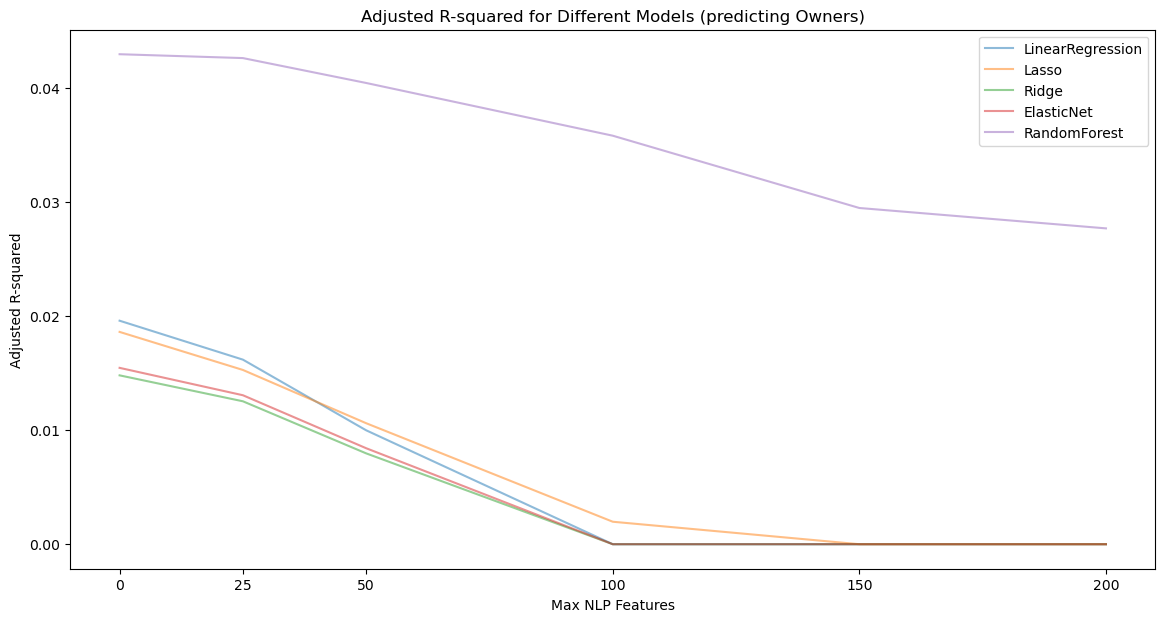

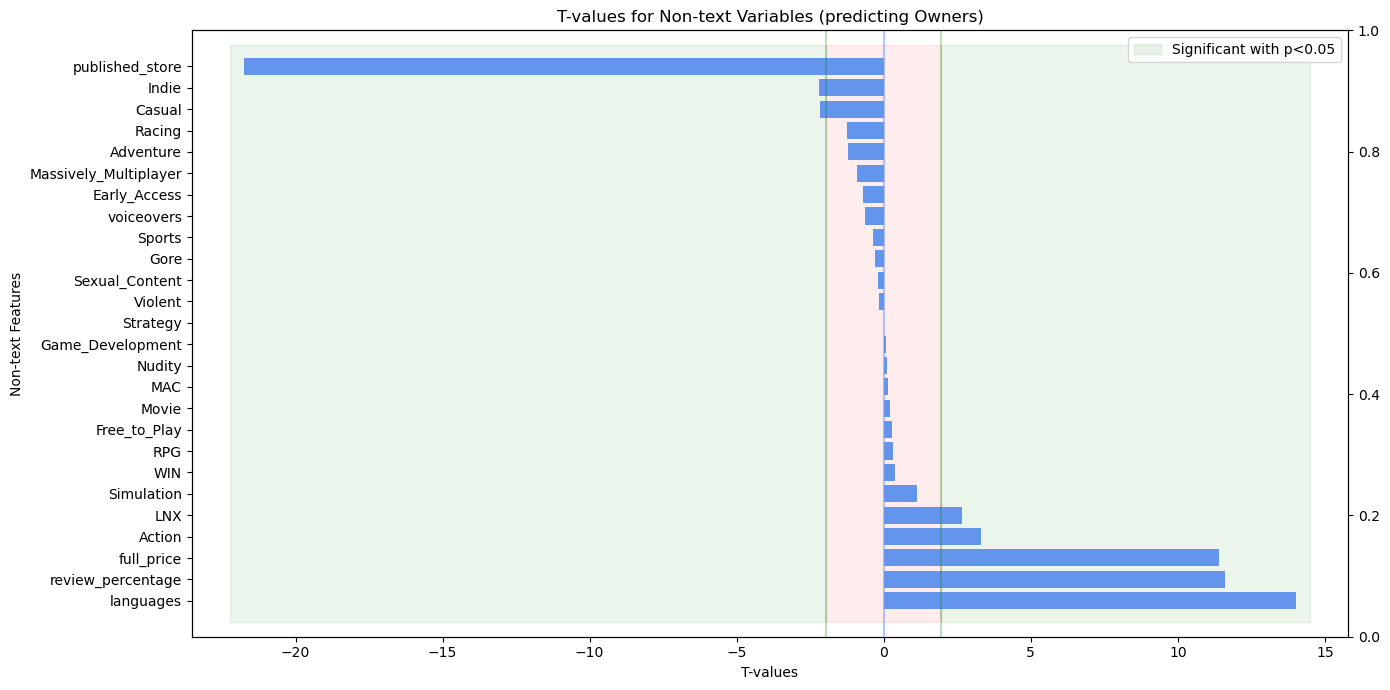

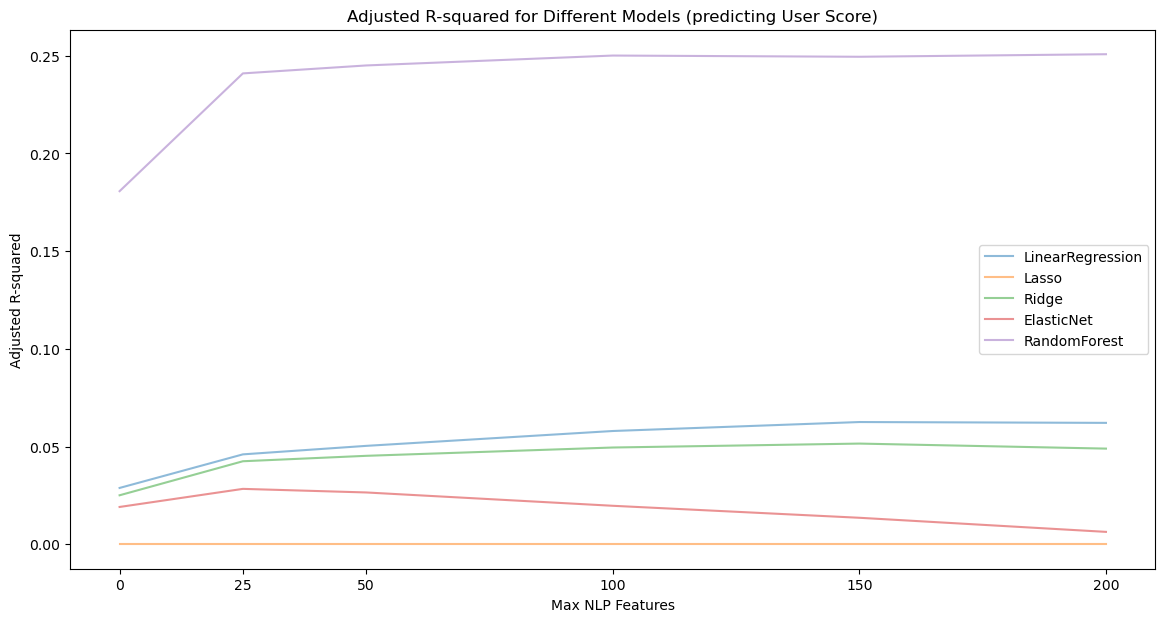

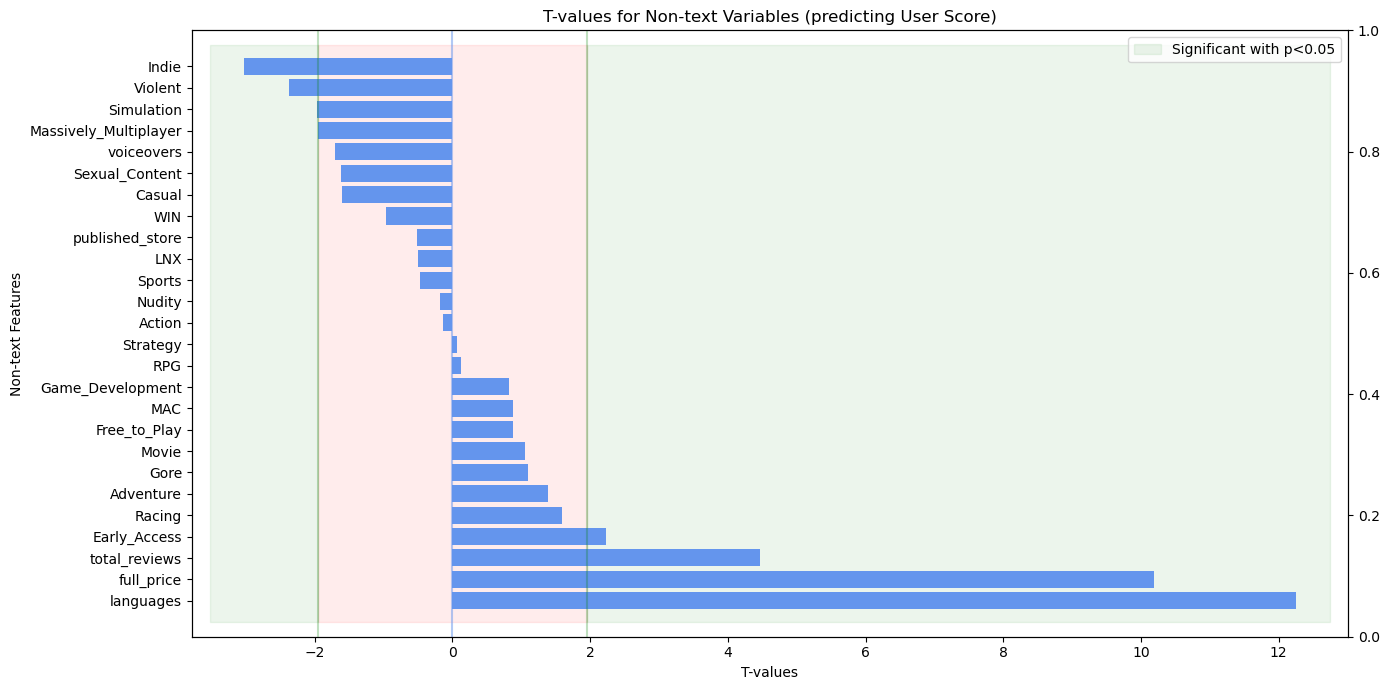

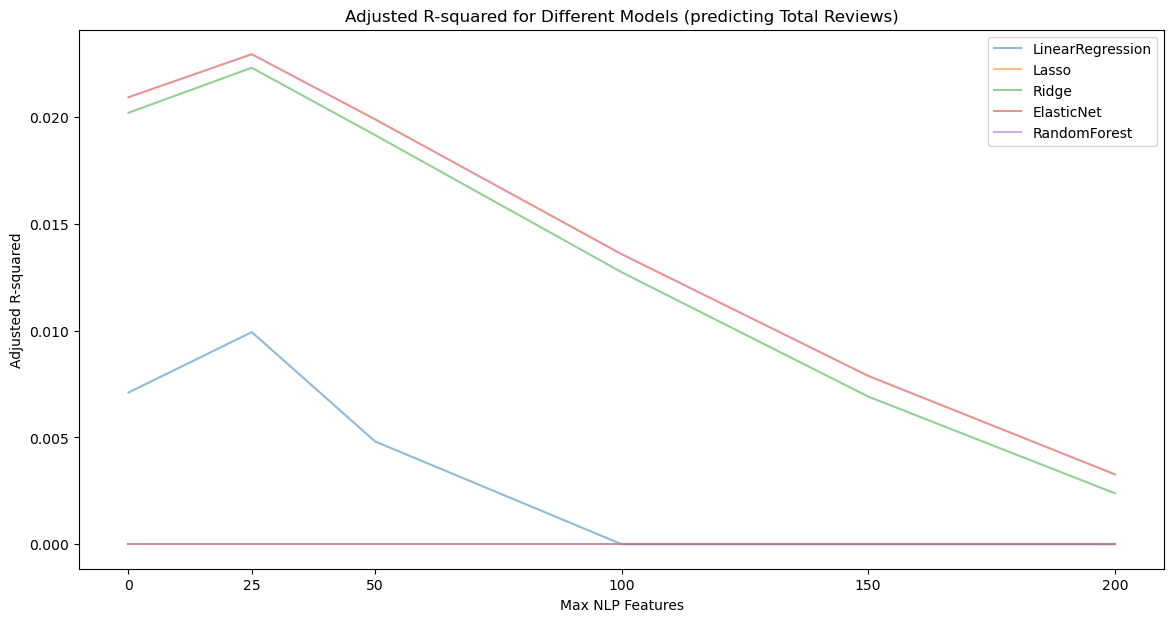

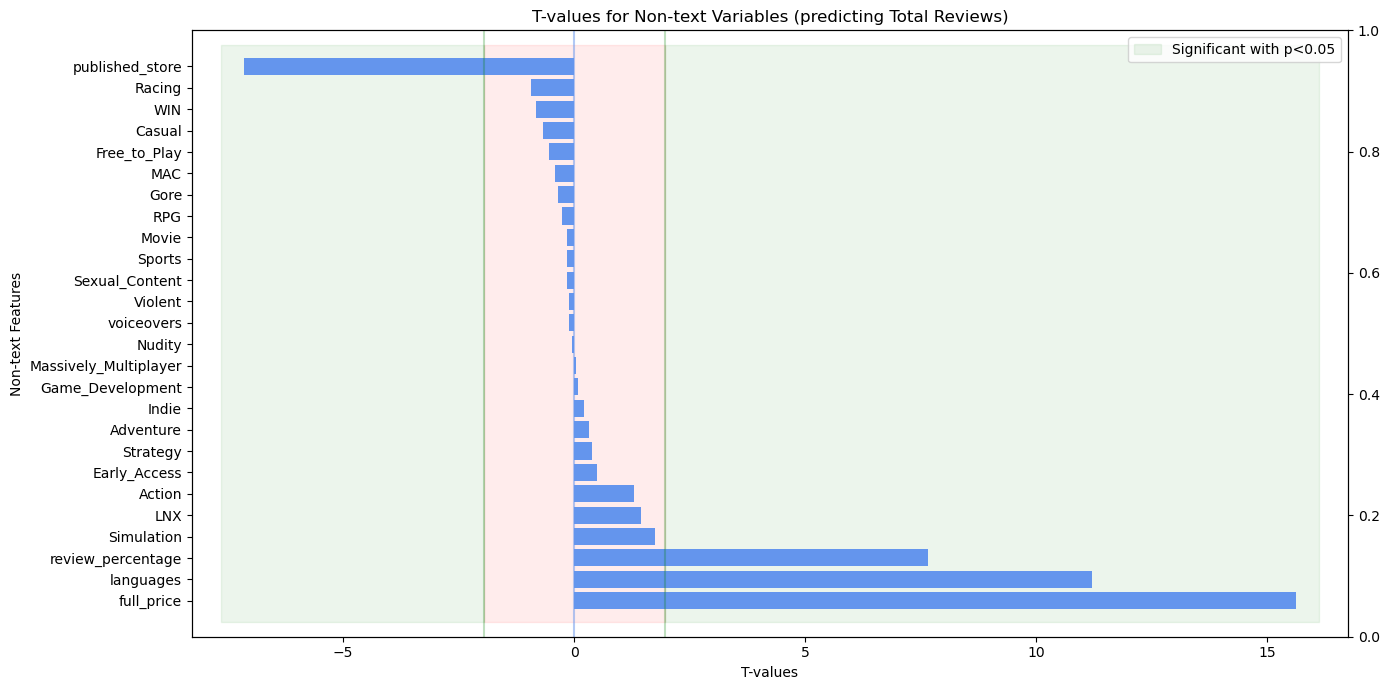

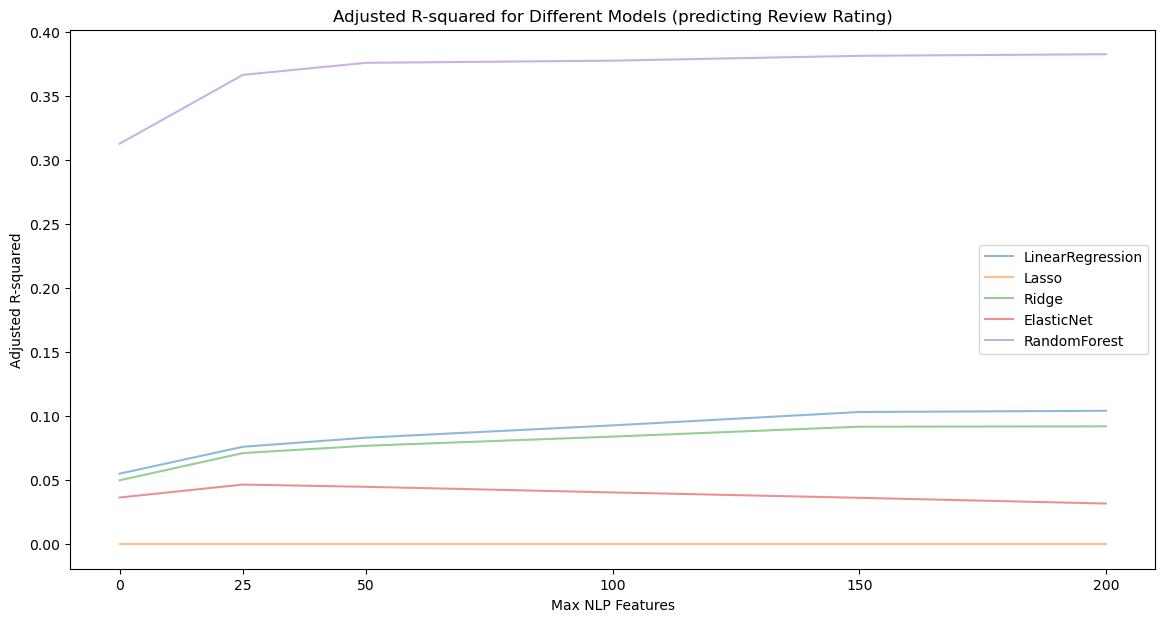

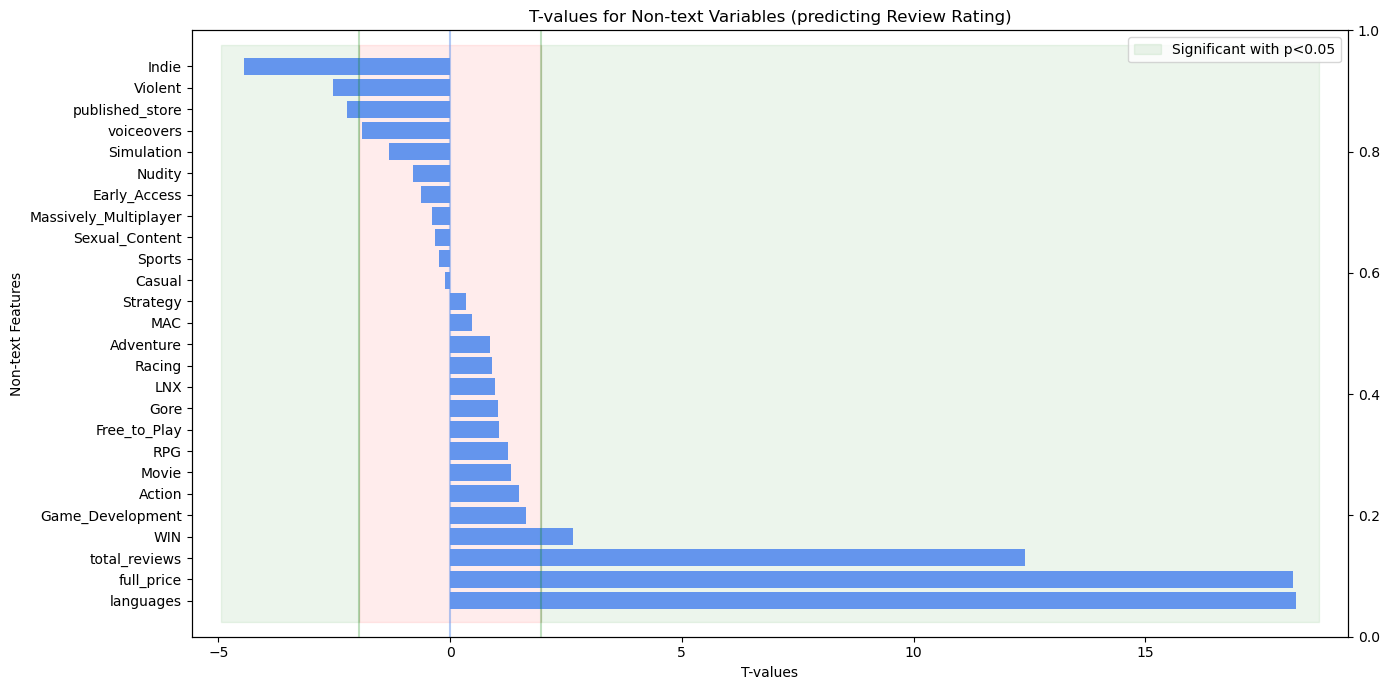

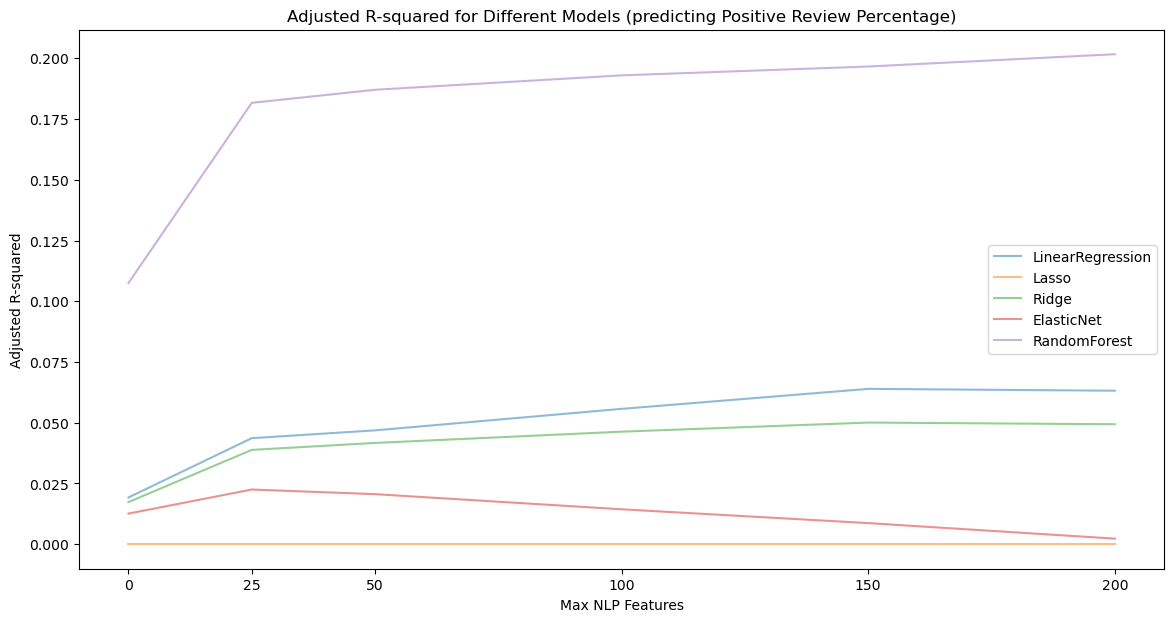

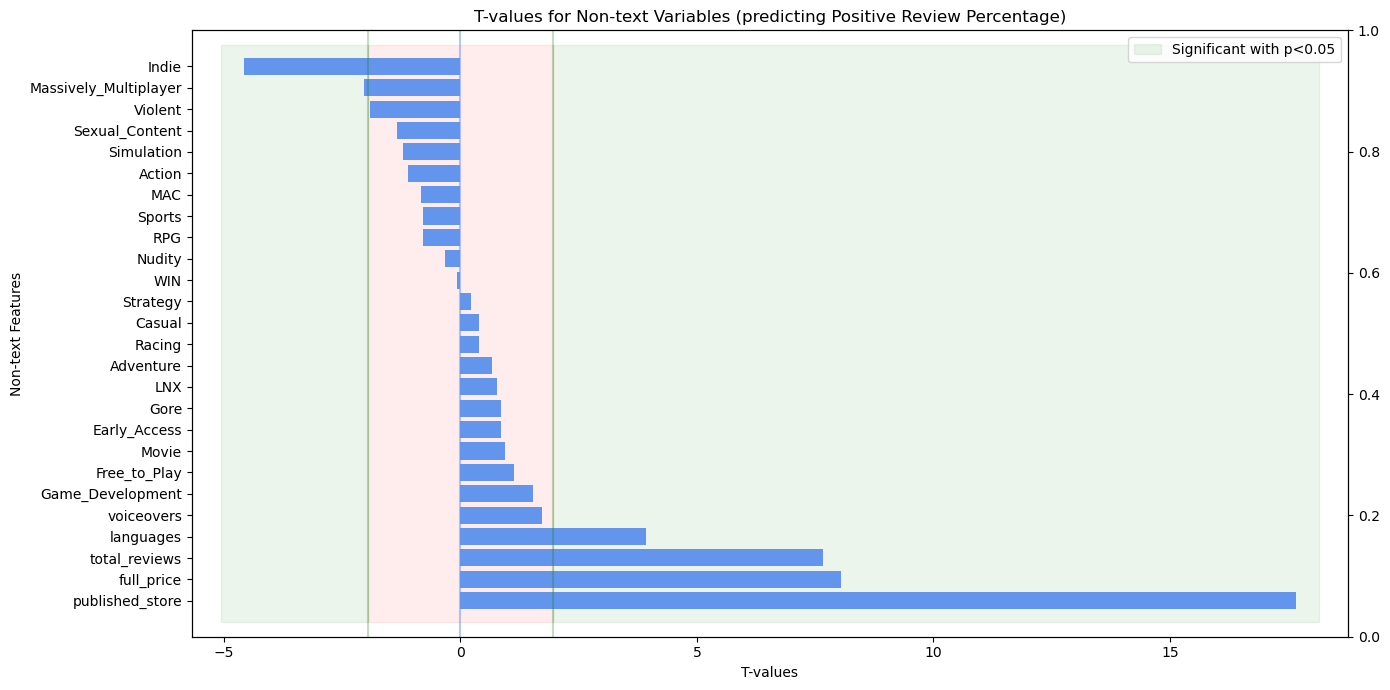

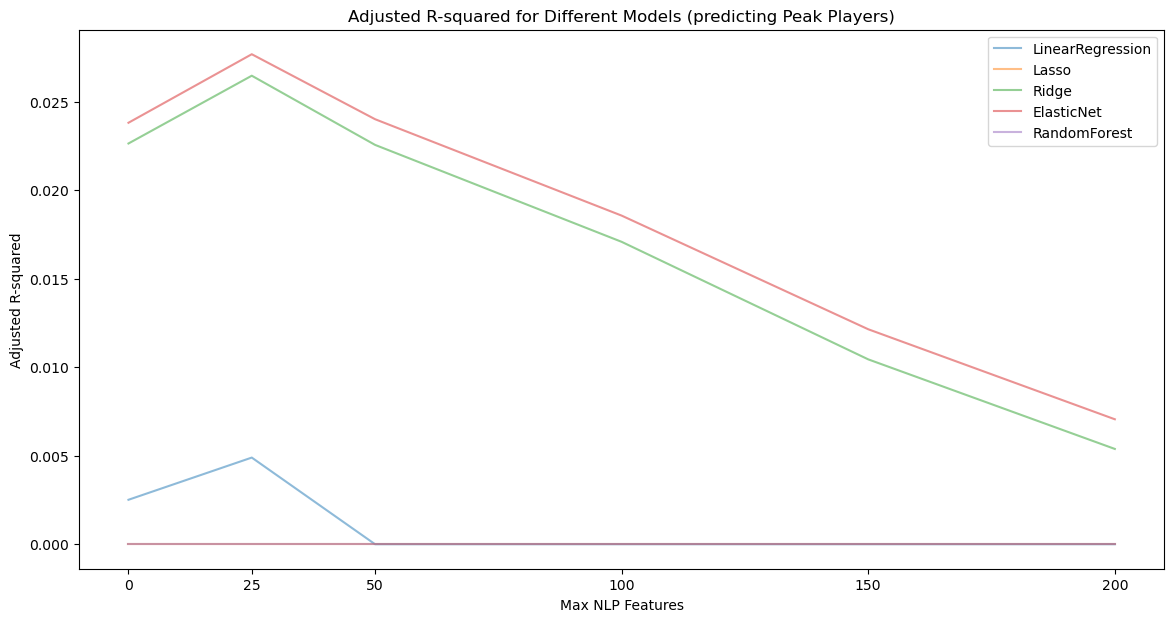

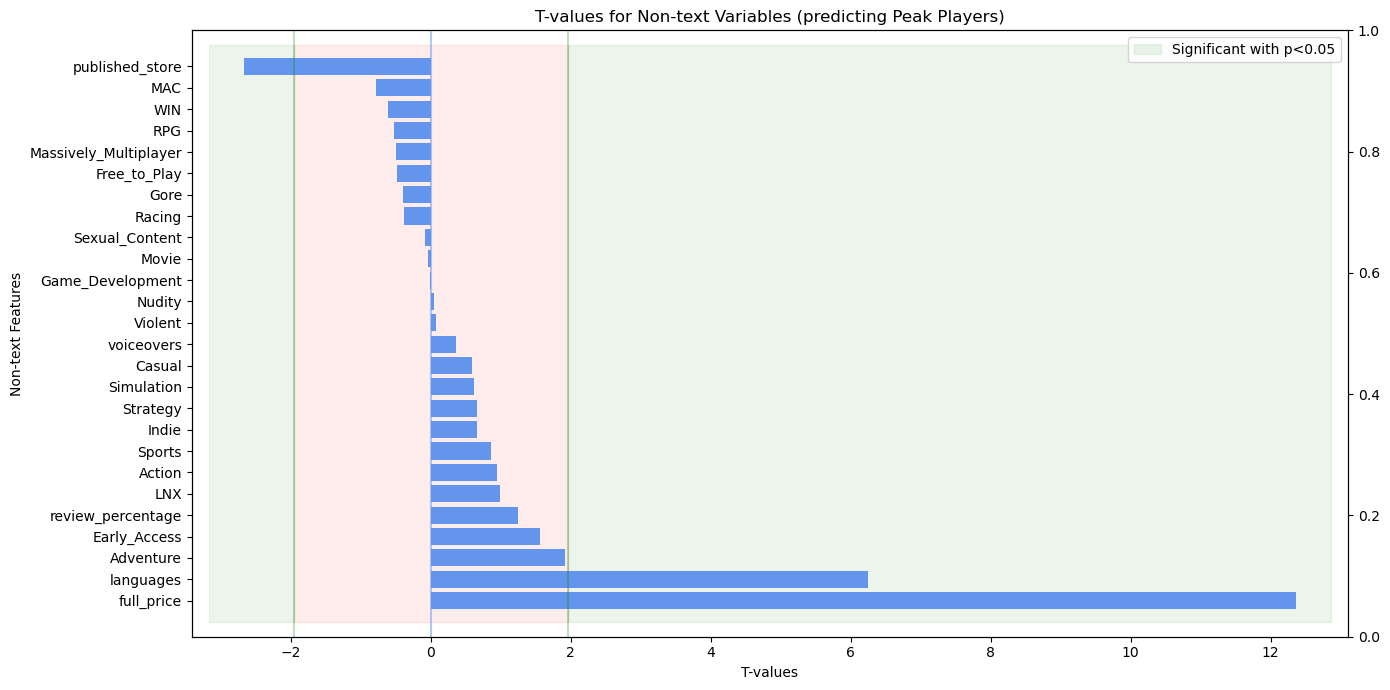

In [6]:
## Use NLPAnalyzer class to conduct basic analyses and save basic plots of results
        
NLP_owners = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "peak_players", "total_reviews", "rating",
                                  "store_uscore", "igdb_popularity"], axis=1), 
                         "stsp_owners", "Owners",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_selected_controls")
results_owners = NLP_owners.analyze()

NLP_uscore = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "peak_players", "review_percentage", "rating",
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "store_uscore", "User Score", 
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_selected_controls")
results_uscore = NLP_uscore.analyze()

NLP_reviews = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "peak_players", "rating",
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "total_reviews", "Total Reviews",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_selected_controls")
results_reviews = NLP_reviews.analyze()

NLP_reviewrating = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "peak_players", "review_percentage",
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "rating", "Review Rating",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_selected_controls")
results_reviewrating = NLP_reviewrating.analyze()

NLP_reviewperc = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "peak_players", "rating",
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "review_percentage", "Positive Review Percentage",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_selected_controls")
results_reviewperc = NLP_reviewperc.analyze()

NLP_peak = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "total_reviews", "rating",
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "peak_players", "Peak Players",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_selected_controls")
results_peak = NLP_peak.analyze()


## Step 4b: Plotting most influential words (using selected controls)

************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


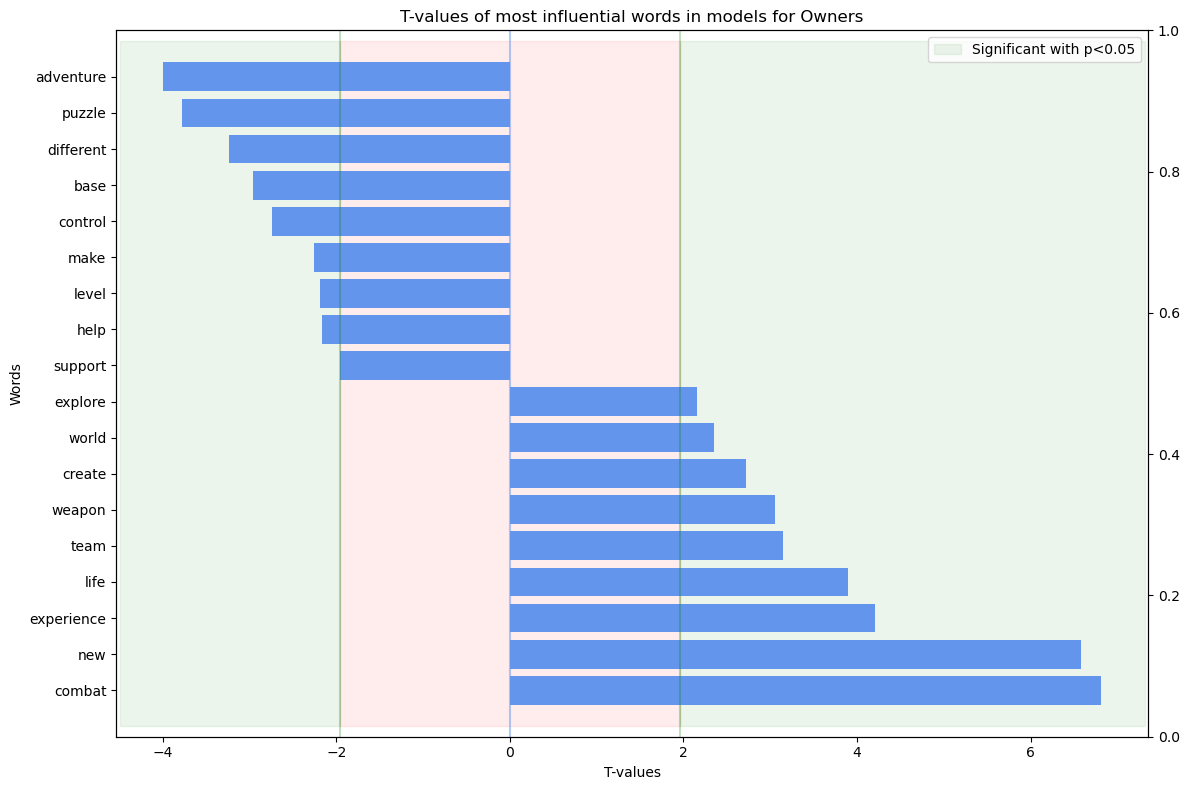

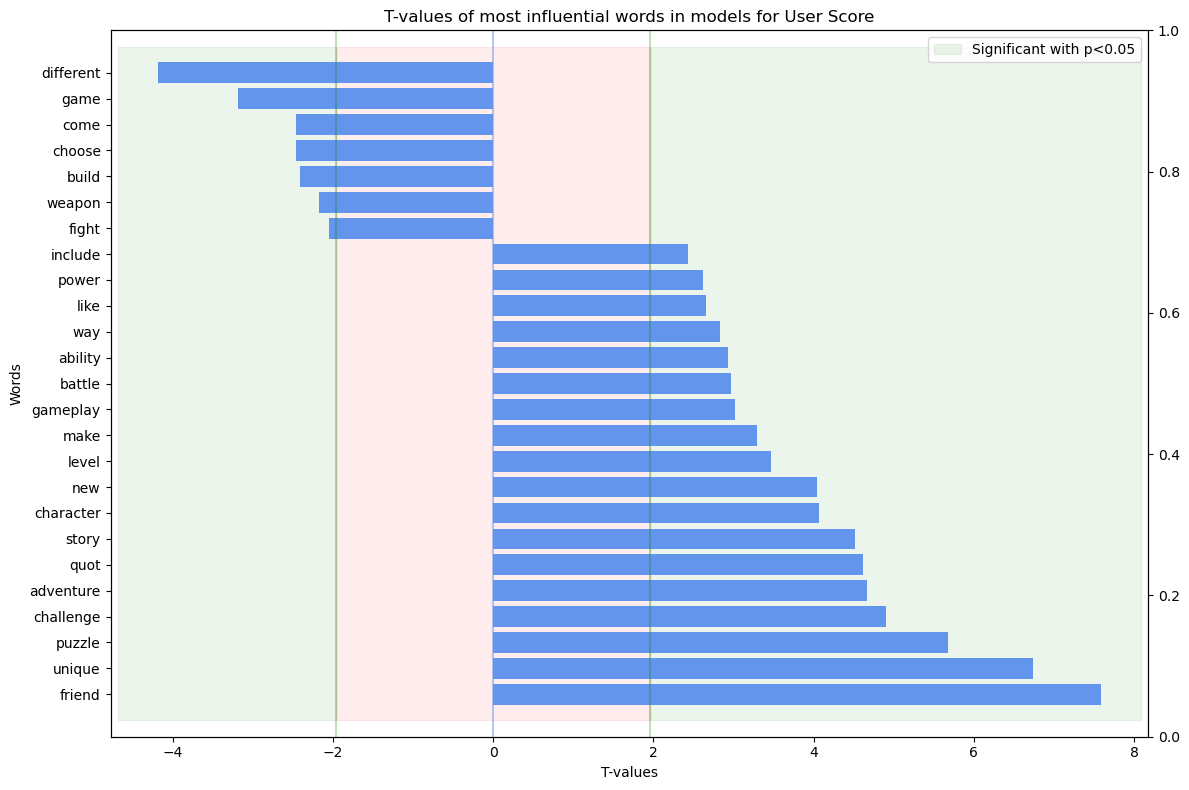

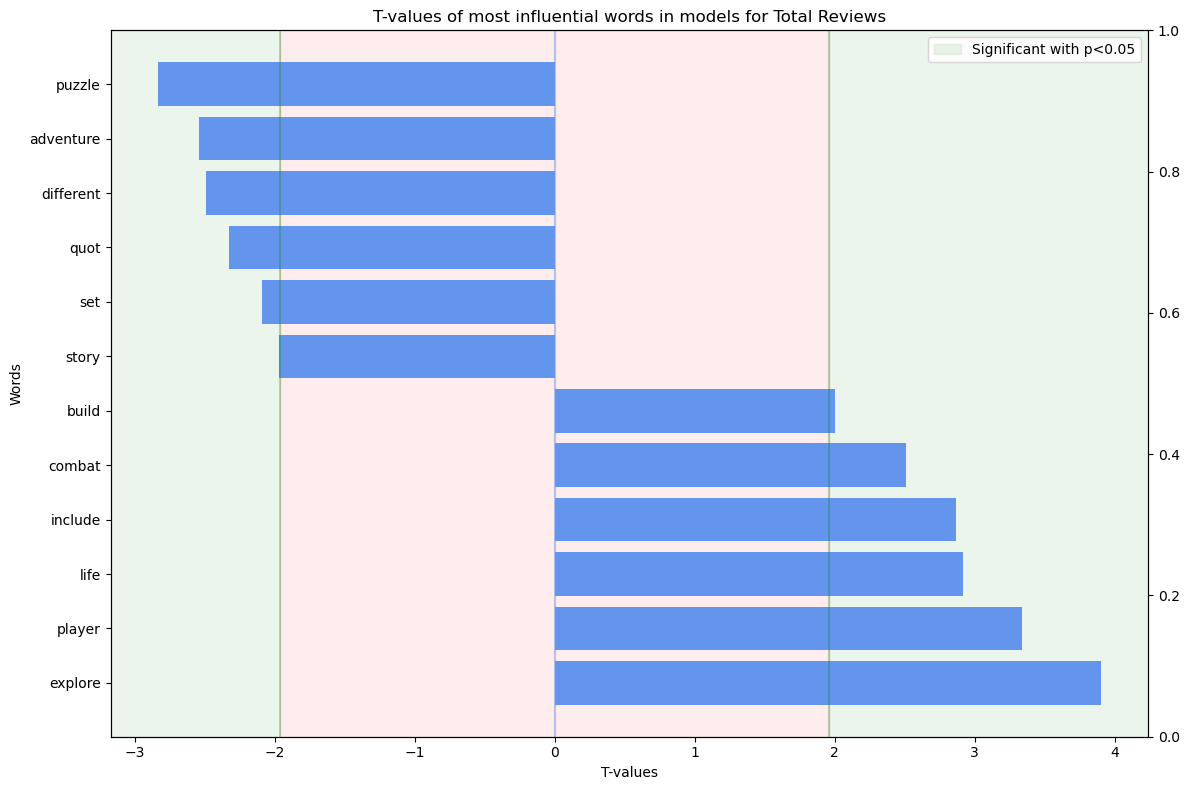

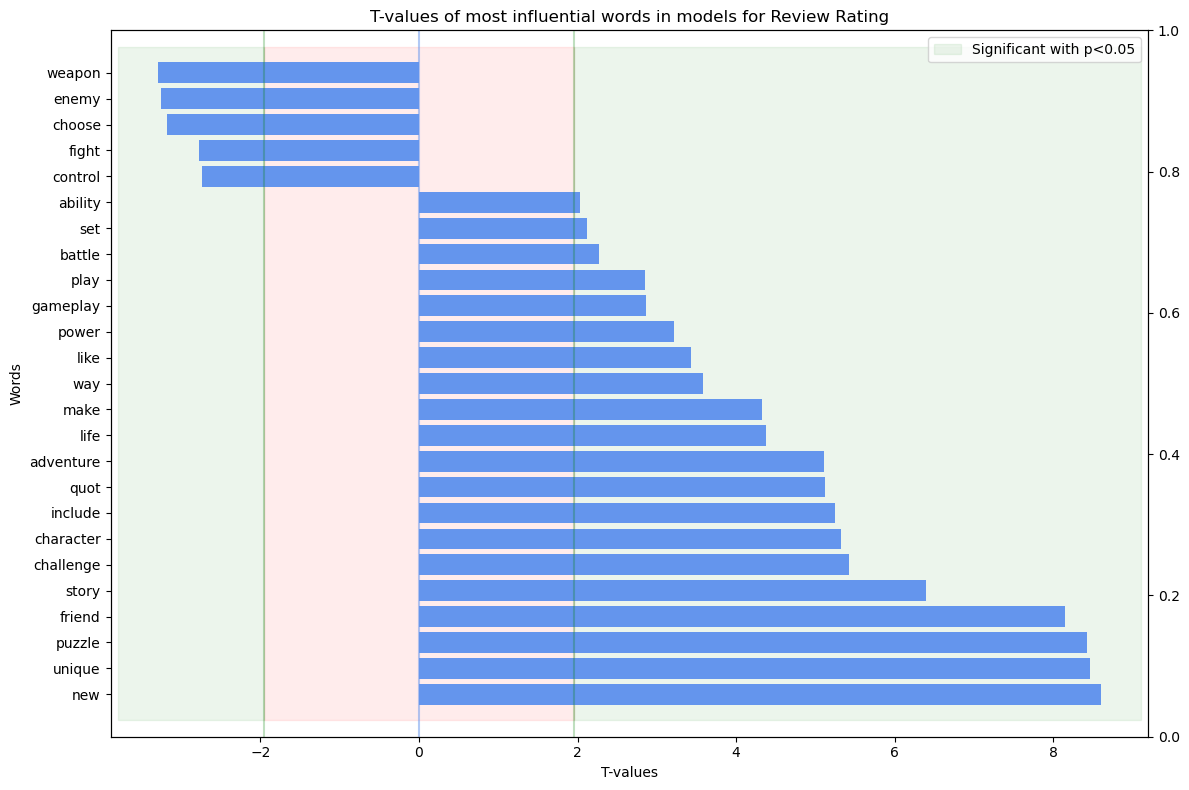

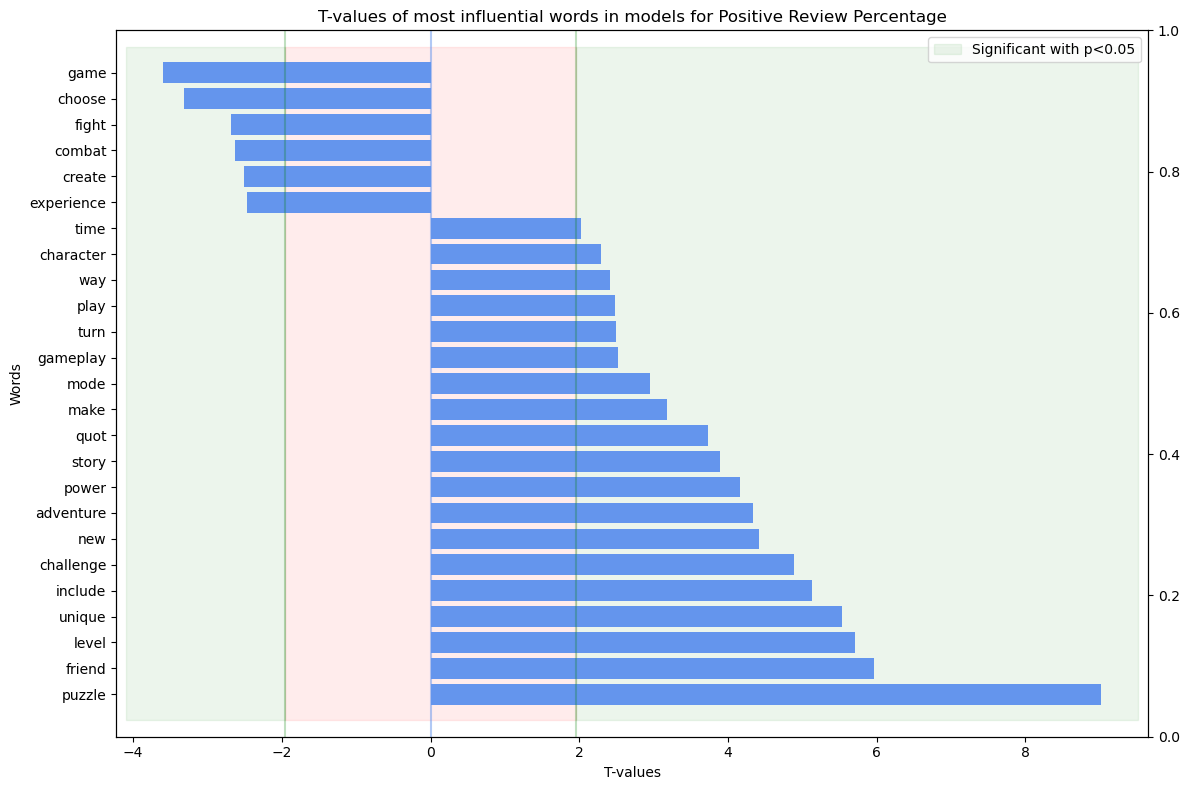

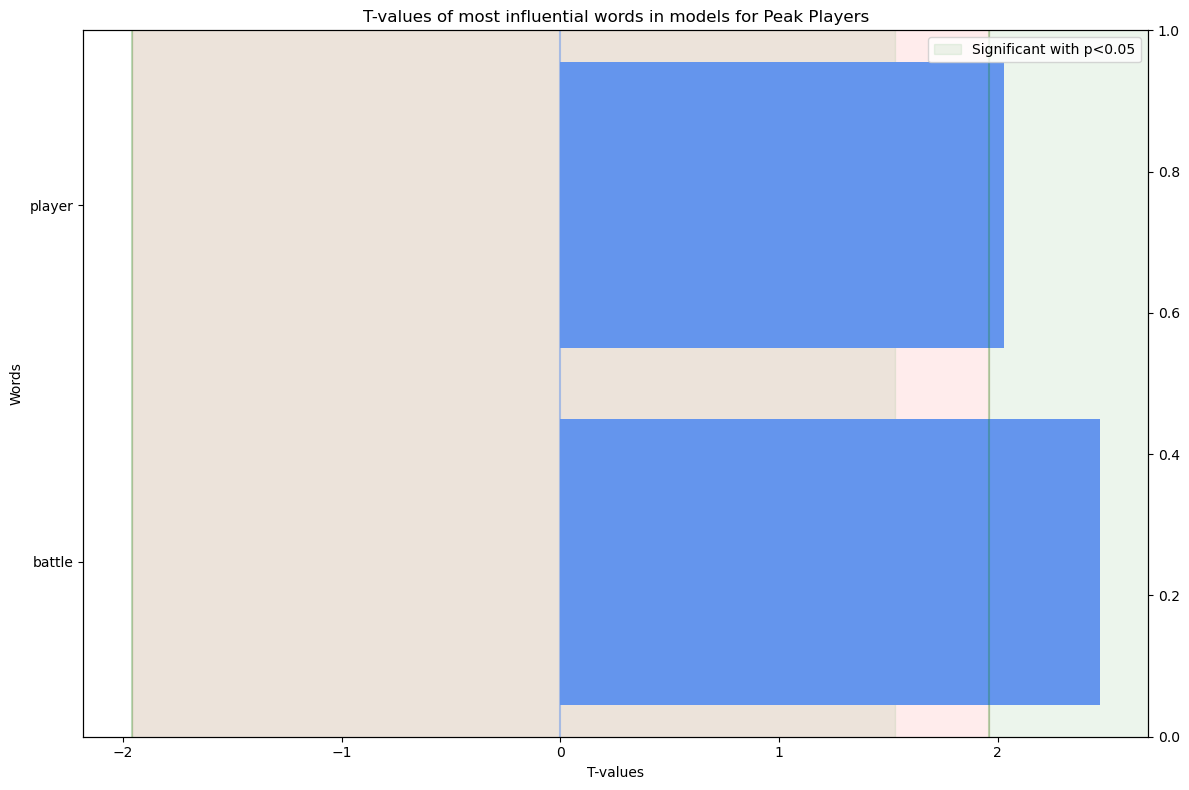

In [7]:
## Get all instances of NLPAnalyzer
nlp_instances = [value for name, value in globals().items() if name.startswith('NLP_') and isinstance(value, NLPAnalyzer)]

## Plot words for all instances
for instance in nlp_instances:
    instance.plot_words()


## Step 5a: Vectorization, analysis and basic plots (using extended controls)

************************************************** 
 Initialization - Target: stsp_owners 
 **************************************************
************************************************** 
 Data preparation done 
 **************************************************
Scaling the following columns for analyses: ['published_store', 'full_price', 'languages', 'voiceovers', 'peak_players', 'total_reviews', 'rating', 'review_percentage']
************************************************** 
 NLP: 0 words - Vectorization done 
 **************************************************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            stsp_owners   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     996.2
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:39:28   Log-Likelihood:            -2.4272e+05
No. Observations:               17118   AIC:                         4.855e+05
Df Residuals:                   17089   BIC:                         4.857e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  4.749e+04   2.02e+05      0.235      0.814   -3.48e+05    4.43e+05
published_store       -7.982e+04   2898.162    -27.542      0.000   -8.55e+04   -7.41e+04
full_price             9328.7982   2808.436      3.322      0.001    3823.975    1.48e+04
languages              1.832e+04   3271.358      5.600      0.000    1.19e+04    2.47e+04
voiceovers            -1045.2163   3176.034     -0.329      0.742   -7270.569    5180.136
peak_players           8.699e+04   3467.716     25.084      0.000    8.02e+04    9.38e+04
total_reviews          3.551e+05   3497.069    101.554      0.000    3.48e+05    3.62e+05
rating                 1.145e+05   9699.420     11.806      0.000    9.55e+04    1.34e+05
review_percentage     -8.877e+04   9513.538     -9.331      0.000   -1.07e+05   -7.01e+04
Strategy               6108.2844   6999.963      0.873      0.383   -7612.363    1.98e+04
Indie                 -2.035e+04   6266.277     -3.247      0.001   -3.26e+04   -8066.505
Movie                 -2.182e-10   3.23e-10     -0.675      0.500   -8.52e-10    4.16e-10
Early_Access          -1.188e+04   8839.534     -1.344      0.179   -2.92e+04    5449.396
Adventure             -9966.4722   5758.782     -1.731      0.084   -2.13e+04    1321.332
Sports                -5362.7783   1.29e+04     -0.415      0.678   -3.07e+04       2e+04
Free_to_Play           5232.8565   1.12e+04      0.466      0.641   -1.68e+04    2.72e+04
Casual                 -1.35e+04   5761.241     -2.343      0.019   -2.48e+04   -2204.434
Simulation            -8120.2942   7103.701     -1.143      0.253    -2.2e+04    5803.690
Action                 2.507e+04   5667.006      4.423      0.000     1.4e+04    3.62e+04
Nudity                 2137.9883   5.01e+04      0.043      0.966    -9.6e+04       1e+05
RPG                    4011.2071   7448.366      0.539      0.590   -1.06e+04    1.86e+04
Violent               -2366.3072   2.94e+04     -0.081      0.936   -5.99e+04    5.52e+04
Sexual_Content         3105.5081   5.09e+04      0.061      0.951   -9.67e+04    1.03e+05
Game_Development       7.839e+04   3.49e+05      0.225      0.822   -6.05e+05    7.62e+05
Massively_Multiplayer -1.786e+04   1.71e+04     -1.047      0.295   -5.13e+04    1.56e+04
Gore                  -7707.5289   3.54e+04     -0.218      0.828    -7.7e+04    6.16e+04
Racing                -2.753e+04   1.42e+04     -1.943      0.052   -5.53e+04     239.241
WIN                    6.904e+04   2.02e+05      0.343      0.732   -3.26e+05    4.64e+05
LNX                    1.533e+04   8545.340      1.794      0.073   -1423.240    3.21e+04
MAC                    -362.3806   7418.911     -0.049      0.961   -1.49e+04    1.42e+04
==============================================================================
Omnibus:                    33751.

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.6200909714845544
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.6194684977998195
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.8627220739727227
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.8619965035391748
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.862722073972723 0.8620208127687788
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
0.8541393417155673 0.8533942370669415
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.7948233782405185 0.793775267965545
**********

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           store_uscore   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     4086.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:41:09   Log-Likelihood:                -56408.
No. Observations:               16755   AIC:                         1.129e+05
Df Residuals:                   16727   BIC:                         1.131e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    74.3045      3.518     21.124      0.000      67.410      81.199
published_store           1.0867      0.059     18.408      0.000       0.971       1.202
full_price               -0.2909      0.058     -5.036      0.000      -0.404      -0.178
languages                -0.2720      0.066     -4.134      0.000      -0.401      -0.143
voiceovers               -0.2238      0.064     -3.508      0.000      -0.349      -0.099
peak_players              0.1613      0.083      1.954      0.051      -0.001       0.323
total_reviews            -0.4775      0.084     -5.689      0.000      -0.642      -0.313
rating                    8.6743      0.201     43.147      0.000       8.280       9.068
review_percentage         9.6225      0.197     48.861      0.000       9.237      10.009
Strategy                 -0.1758      0.142     -1.236      0.216      -0.454       0.103
Indie                     0.2506      0.127      1.967      0.049       0.001       0.500
Movie                  2.175e-15   6.56e-16      3.317      0.001     8.9e-16    3.46e-15
Early_Access             -0.0015      0.180     -0.008      0.994      -0.355       0.352
Adventure                 0.0078      0.117      0.067      0.947      -0.221       0.237
Sports                   -0.1886      0.266     -0.709      0.478      -0.710       0.333
Free_to_Play              0.1116      0.225      0.496      0.620      -0.329       0.553
Casual                   -0.0581      0.117     -0.495      0.621      -0.288       0.172
Simulation               -0.0770      0.145     -0.532      0.595      -0.361       0.207
Action                    0.1545      0.115      1.339      0.181      -0.072       0.381
Nudity                    0.7785      0.952      0.817      0.414      -1.088       2.645
RPG                       0.0553      0.151      0.365      0.715      -0.241       0.352
Violent                  -0.0057      0.580     -0.010      0.992      -1.143       1.131
Sexual_Content           -0.1197      0.966     -0.124      0.901      -2.013       1.773
Game_Development       4.346e-16   2.22e-16      1.957      0.050   -5.96e-19     8.7e-16
Massively_Multiplayer     0.3057      0.341      0.897      0.370      -0.362       0.974
Gore                     -0.1277      0.700     -0.183      0.855      -1.499       1.244
Racing                   -0.2802      0.290     -0.967      0.334      -0.849       0.288
WIN                      -1.2033      3.515     -0.342      0.732      -8.093       5.686
LNX                      -0.3781      0.173     -2.180      0.029      -0.718      -0.038
MAC                      -0.1093      0.150     -0.727      0.467      -0.404       0.186
==============================================================================
Omnibus:                     2680.

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.868353987075968
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.8681414897752596
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.8630445151709505
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.8623047484181828
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.8630445151709506 0.8623295360422301
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-2.2054862702791667e-06 -0.005222739052265224
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.8158928467113604 0.8149317112576484
*

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          total_reviews   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     1028.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:43:22   Log-Likelihood:            -2.6892e+05
No. Observations:               23964   AIC:                         5.379e+05
Df Residuals:                   23935   BIC:                         5.381e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3256.1620    799.850      4.071      0.000    1688.406    4823.918
published_store        -608.1890    130.506     -4.660      0.000    -863.989    -352.389
full_price             1153.2980    124.838      9.238      0.000     908.608    1397.988
languages              1033.6043    141.356      7.312      0.000     756.537    1310.672
voiceovers               34.6585    137.679      0.252      0.801    -235.200     304.517
peak_players           1.918e+04    117.828    162.740      0.000    1.89e+04    1.94e+04
rating                 6480.6274    396.127     16.360      0.000    5704.194    7257.061
review_percentage     -5041.7839    392.272    -12.853      0.000   -5810.661   -4272.907
Strategy               -114.3403    311.949     -0.367      0.714    -725.780     497.100
Indie                   -66.3326    275.207     -0.241      0.810    -605.755     473.090
Movie                 -3291.2430   1.81e+04     -0.182      0.856   -3.88e+04    3.22e+04
Early_Access           -205.2942    370.878     -0.554      0.580    -932.238     521.650
Adventure              -498.6955    253.111     -1.970      0.049    -994.810      -2.581
Sports                 -766.1638    582.030     -1.316      0.188   -1906.979     374.652
Free_to_Play           -161.0285    464.511     -0.347      0.729   -1071.500     749.443
Casual                 -470.9604    252.980     -1.862      0.063    -966.818      24.897
Simulation              608.0868    312.327      1.947      0.052      -4.094    1220.267
Action                  164.0987    250.936      0.654      0.513    -327.751     655.948
Nudity                 -901.7384   2638.958     -0.342      0.733   -6074.263    4270.786
RPG                      43.6593    328.145      0.133      0.894    -599.525     686.844
Violent                -245.1766   1465.781     -0.167      0.867   -3118.200    2627.847
Sexual_Content          -42.0227   2705.415     -0.016      0.988   -5344.807    5260.762
Game_Development         93.2822   1.28e+04      0.007      0.994    -2.5e+04    2.52e+04
Massively_Multiplayer   149.4870    756.392      0.198      0.843   -1333.090    1632.064
Gore                   -237.6261   1805.101     -0.132      0.895   -3775.739    3300.487
Racing                 -648.3727    634.876     -1.021      0.307   -1892.769     596.024
WIN                    -706.6879    867.277     -0.815      0.415   -2406.605     993.229
LNX                     421.3063    392.600      1.073      0.283    -348.215    1190.828
MAC                      62.9178    338.246      0.186      0.852    -600.065     725.901
==============================================================================
Omnibus:                    65286.818   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarqu

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.5459276089849754
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.5453964192231864
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.4198950025892011
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.4177812891924285
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.4198950025892014 0.4178544322465503
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
0.24686402998350332 0.2442148079784202
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.34072731009716495 0.33840826043419014
*****

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     9068.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:46:53   Log-Likelihood:                -68215.
No. Observations:               23964   AIC:                         1.365e+05
Df Residuals:                   23935   BIC:                         1.367e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    67.2691      0.184    365.075      0.000      66.908      67.630
published_store          -1.0318      0.029    -35.163      0.000      -1.089      -0.974
full_price                1.2108      0.028     43.649      0.000       1.156       1.265
languages                 0.8238      0.032     25.603      0.000       0.761       0.887
voiceovers               -0.1700      0.032     -5.362      0.000      -0.232      -0.108
peak_players             -0.3200      0.039     -8.129      0.000      -0.397      -0.243
total_reviews             0.6506      0.040     16.360      0.000       0.573       0.729
review_percentage        13.3832      0.027    489.810      0.000      13.330      13.437
Strategy                  0.1217      0.072      1.694      0.090      -0.019       0.263
Indie                    -0.0963      0.063     -1.519      0.129      -0.221       0.028
Movie                     5.5910      4.177      1.339      0.181      -2.595      13.777
Early_Access             -0.1104      0.085     -1.292      0.197      -0.278       0.057
Adventure                 0.0943      0.058      1.616      0.106      -0.020       0.209
Sports                    0.1204      0.134      0.898      0.369      -0.142       0.383
Free_to_Play             -0.0597      0.107     -0.557      0.577      -0.270       0.150
Casual                   -0.0335      0.058     -0.575      0.565      -0.148       0.081
Simulation               -0.0331      0.072     -0.460      0.646      -0.174       0.108
Action                    0.1861      0.058      3.219      0.001       0.073       0.299
Nudity                    0.4265      0.608      0.701      0.483      -0.766       1.619
RPG                       0.0399      0.076      0.527      0.598      -0.108       0.188
Violent                  -0.2529      0.338     -0.749      0.454      -0.915       0.409
Sexual_Content           -0.3139      0.624     -0.503      0.615      -1.536       0.908
Game_Development         -0.7768      2.951     -0.263      0.792      -6.560       5.007
Massively_Multiplayer     0.1313      0.174      0.753      0.451      -0.210       0.473
Gore                     -0.2966      0.416     -0.713      0.476      -1.112       0.519
Racing                   -0.0320      0.146     -0.219      0.827      -0.319       0.255
WIN                       0.7823      0.200      3.915      0.000       0.391       1.174
LNX                       0.1457      0.090      1.610      0.107      -0.032       0.323
MAC                       0.1302      0.078      1.670      0.095      -0.023       0.283
==============================================================================
Omnibus:                     6650.826   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarqu

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.9138491778959994
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.9137483956516329
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.9096927489224438
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.9093636987551804
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.9096927489224437 0.909375085225186
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-0.0017303591069630642 -0.005254033736987518
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.8346336610391554 0.8340519703995946
**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      review_percentage   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     8834.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:49:22   Log-Likelihood:                -75465.
No. Observations:               23964   AIC:                         1.510e+05
Df Residuals:                   23935   BIC:                         1.512e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    75.1926      0.249    301.537      0.000      74.704      75.681
published_store           1.5303      0.040     38.741      0.000       1.453       1.608
full_price               -1.4461      0.038    -38.188      0.000      -1.520      -1.372
languages                -1.0056      0.044    -23.034      0.000      -1.091      -0.920
voiceovers                0.2389      0.043      5.568      0.000       0.155       0.323
peak_players              0.3145      0.053      5.900      0.000       0.210       0.419
total_reviews            -0.6931      0.054    -12.853      0.000      -0.799      -0.587
rating                   18.3280      0.037    489.810      0.000      18.255      18.401
Strategy                 -0.1430      0.097     -1.469      0.142      -0.334       0.048
Indie                     0.0232      0.086      0.270      0.787      -0.145       0.191
Movie                    -5.0955      5.652     -0.902      0.367     -16.174       5.983
Early_Access              0.1821      0.116      1.575      0.115      -0.045       0.409
Adventure                -0.0897      0.079     -1.136      0.256      -0.244       0.065
Sports                   -0.1839      0.182     -1.013      0.311      -0.540       0.172
Free_to_Play              0.1378      0.145      0.951      0.342      -0.146       0.422
Casual                    0.0505      0.079      0.640      0.522      -0.104       0.205
Simulation                0.0073      0.097      0.075      0.940      -0.184       0.198
Action                   -0.2638      0.078     -3.372      0.001      -0.417      -0.110
Nudity                   -0.6362      0.823     -0.773      0.440      -2.249       0.977
RPG                      -0.0651      0.102     -0.636      0.525      -0.266       0.136
Violent                   0.0578      0.457      0.126      0.899      -0.838       0.954
Sexual_Content            0.0300      0.844      0.036      0.972      -1.624       1.684
Game_Development          2.8965      3.993      0.725      0.468      -4.930      10.723
Massively_Multiplayer    -0.3053      0.236     -1.294      0.196      -0.768       0.157
Gore                      0.5113      0.563      0.908      0.364      -0.592       1.615
Racing                    0.0952      0.198      0.481      0.631      -0.293       0.483
WIN                      -0.9520      0.270     -3.520      0.000      -1.482      -0.422
LNX                      -0.1469      0.122     -1.200      0.230      -0.387       0.093
MAC                      -0.1870      0.105     -1.773      0.076      -0.394       0.020
==============================================================================
Omnibus:                     6901.898   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarqu

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.9117740317994779
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.9116708219766405
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.9086136645116017
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.908280682512712
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.9086136645116019 0.9082922050400346
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
-0.0013072929645041587 -0.004829479422168159
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.824273132480249 0.8236549977703805
***

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           peak_players   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     974.0
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:51:30   Log-Likelihood:            -2.6853e+05
No. Observations:               23964   AIC:                         5.371e+05
Df Residuals:                   23935   BIC:                         5.374e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   803.9851    786.888      1.022      0.307    -738.365    2346.336
published_store         274.7633    128.435      2.139      0.032      23.023     526.503
full_price              269.8031    123.019      2.193      0.028      28.678     510.928
languages              -228.1718    139.211     -1.639      0.101    -501.033      44.690
voiceovers               55.2810    135.445      0.408      0.683    -210.199     320.761
total_reviews          1.914e+04    117.607    162.740      0.000    1.89e+04    1.94e+04
rating                -3181.2070    391.334     -8.129      0.000   -3948.246   -2414.168
review_percentage      2283.0469    386.956      5.900      0.000    1524.588    3041.505
Strategy                191.3116    306.887      0.623      0.533    -410.206     792.829
Indie                   172.4703    270.740      0.637      0.524    -358.198     703.138
Movie                  1574.8626   1.78e+04      0.088      0.930   -3.34e+04    3.65e+04
Early_Access            582.4253    364.844      1.596      0.110    -132.692    1297.543
Adventure               646.2263    248.990      2.595      0.009     158.189    1134.263
Sports                  784.0899    572.586      1.369      0.171    -338.215    1906.395
Free_to_Play            -56.4807    456.977     -0.124      0.902    -952.184     839.222
Casual                  411.6950    248.880      1.654      0.098     -76.125     899.516
Simulation             -306.0478    307.278     -0.996      0.319    -908.332     296.237
Action                   41.3984    246.867      0.168      0.867    -442.476     525.273
Nudity                  397.7293   2596.152      0.153      0.878   -4690.892    5486.351
RPG                    -143.7274    322.820     -0.445      0.656    -776.475     489.020
Violent                 249.9851   1442.002      0.173      0.862   -2576.430    3076.400
Sexual_Content           23.9660   2661.526      0.009      0.993   -5192.793    5240.725
Game_Development        156.8843   1.26e+04      0.012      0.990   -2.45e+04    2.48e+04
Massively_Multiplayer  -465.0138    744.116     -0.625      0.532   -1923.529     993.501
Gore                   -204.6454   1775.818     -0.115      0.908   -3685.361    3276.070
Racing                  283.1256    624.587      0.453      0.650    -941.105    1507.356
WIN                      56.2363    853.219      0.066      0.947   -1616.127    1728.600
LNX                     -63.4688    386.240     -0.164      0.869    -820.524     693.587
MAC                    -223.0091    332.755     -0.670      0.503    -875.231     429.213
==============================================================================
Omnibus:                    67665.954   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarqu

************************************************** 
 R-squared for Statsmodels OLS (train data): 0.5325895645659269
************************************************** 
 Adjusted R-squared for Statsmodels OLS (train data): 0.5320427714933489
************************************************** 
 R-squared for Statsmodels OLS (test data): 0.17890915587125567
************************************************** 
 Adjusted R-squared for Statsmodels OLS (test data): 0.1759173686517892
************************************************** 
 NLP: 0 words - OLS SM done 
 **************************************************
0.17890915587125378 0.17602089662054965
************************************************** 
 NLP: 0 words - OLS SK done 
 **************************************************
0.47061664933716485 0.4687544968473961
************************************************** 
 NLP: 0 words - Lasso done 
 **************************************************
0.45460497016743695 0.4526864951881264
***

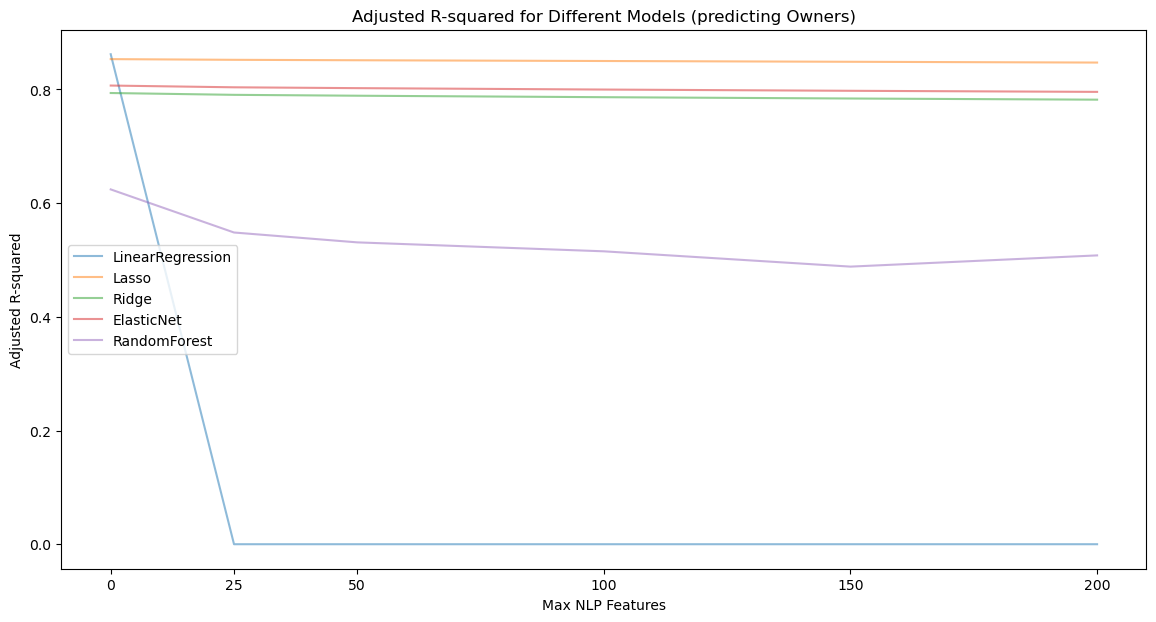

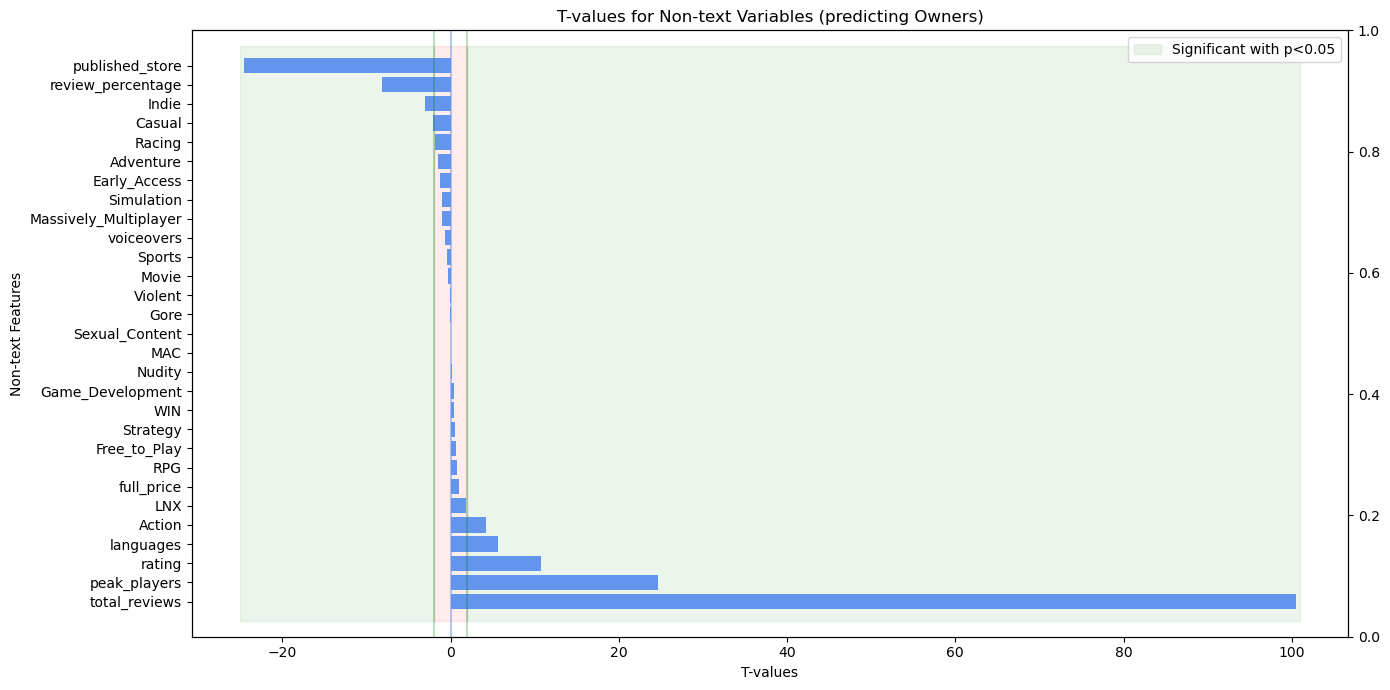

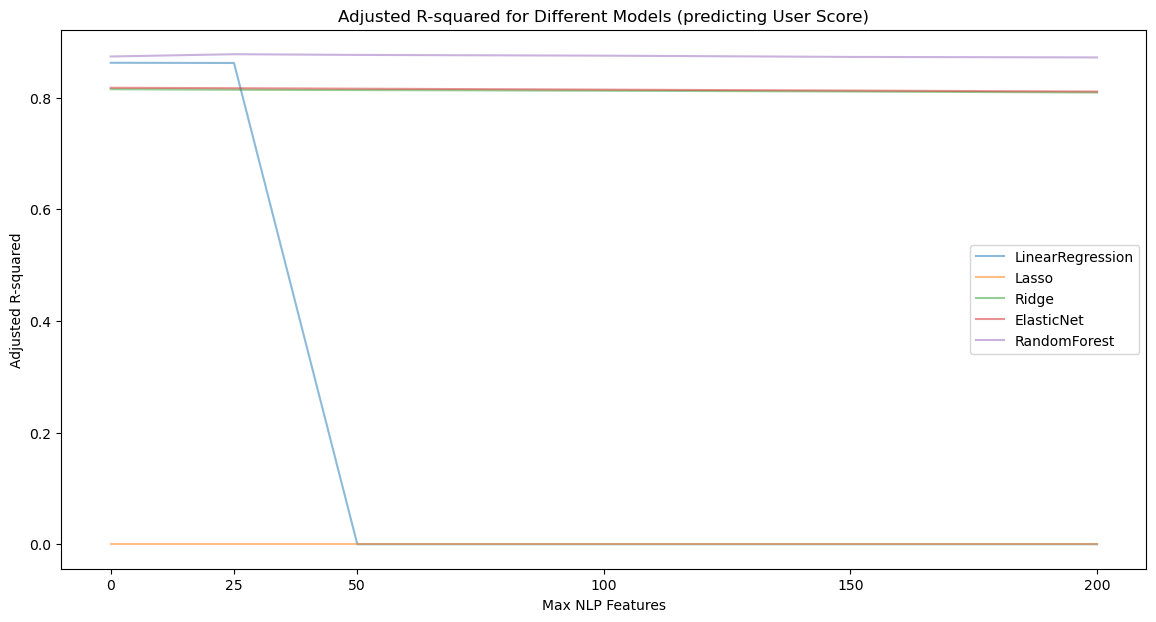

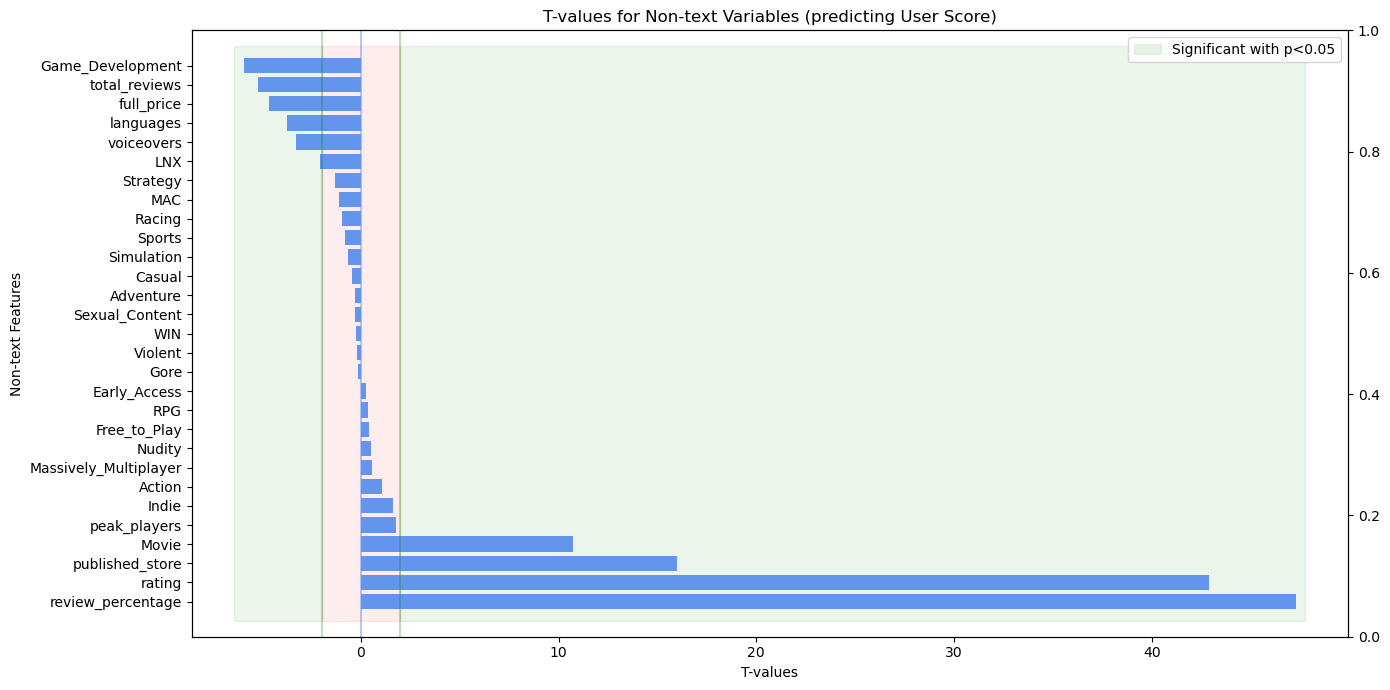

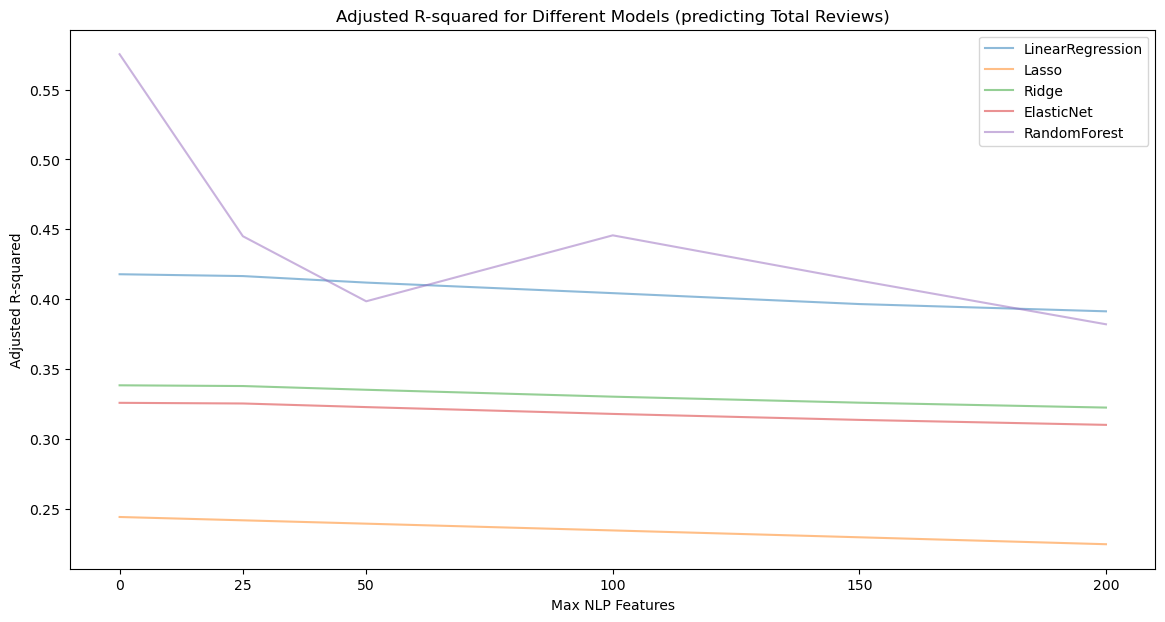

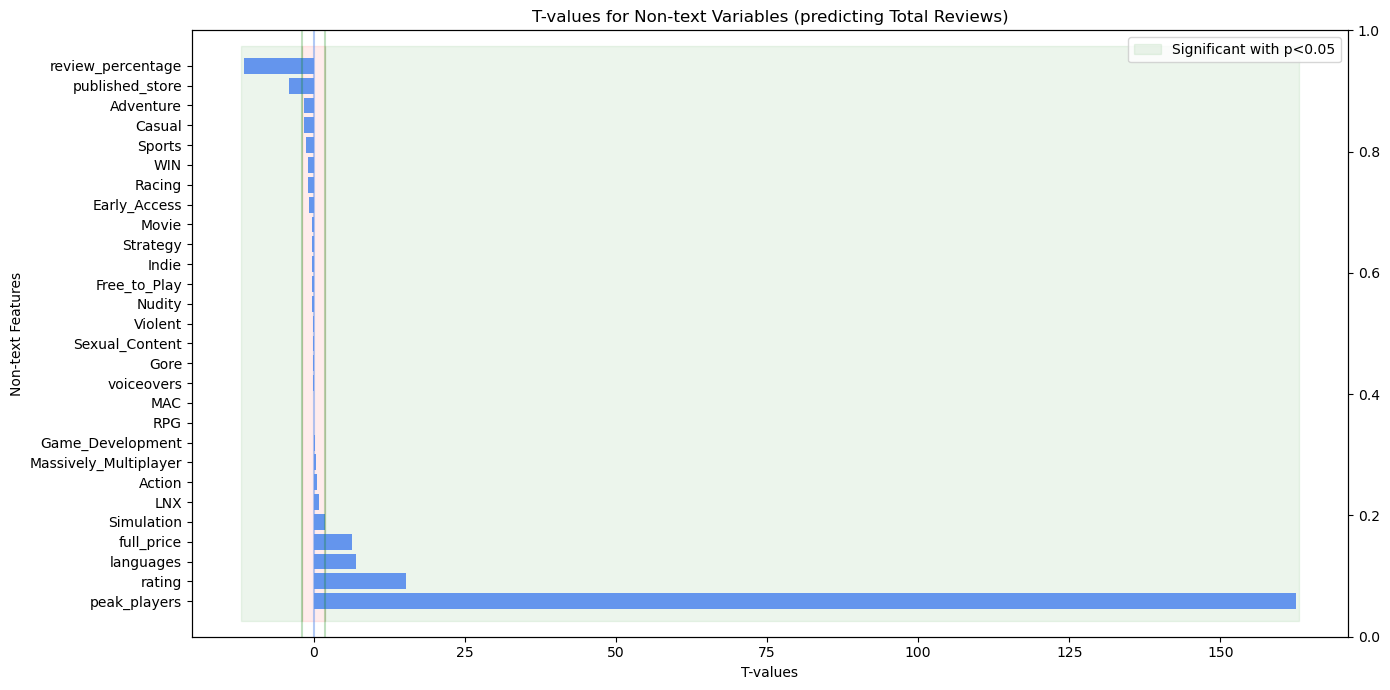

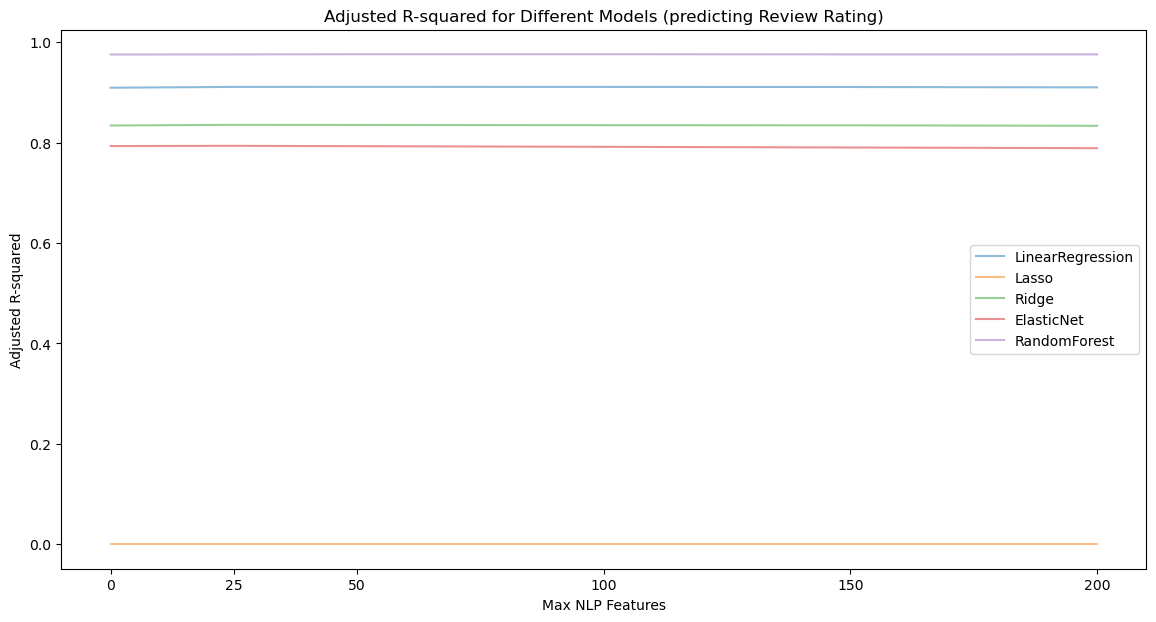

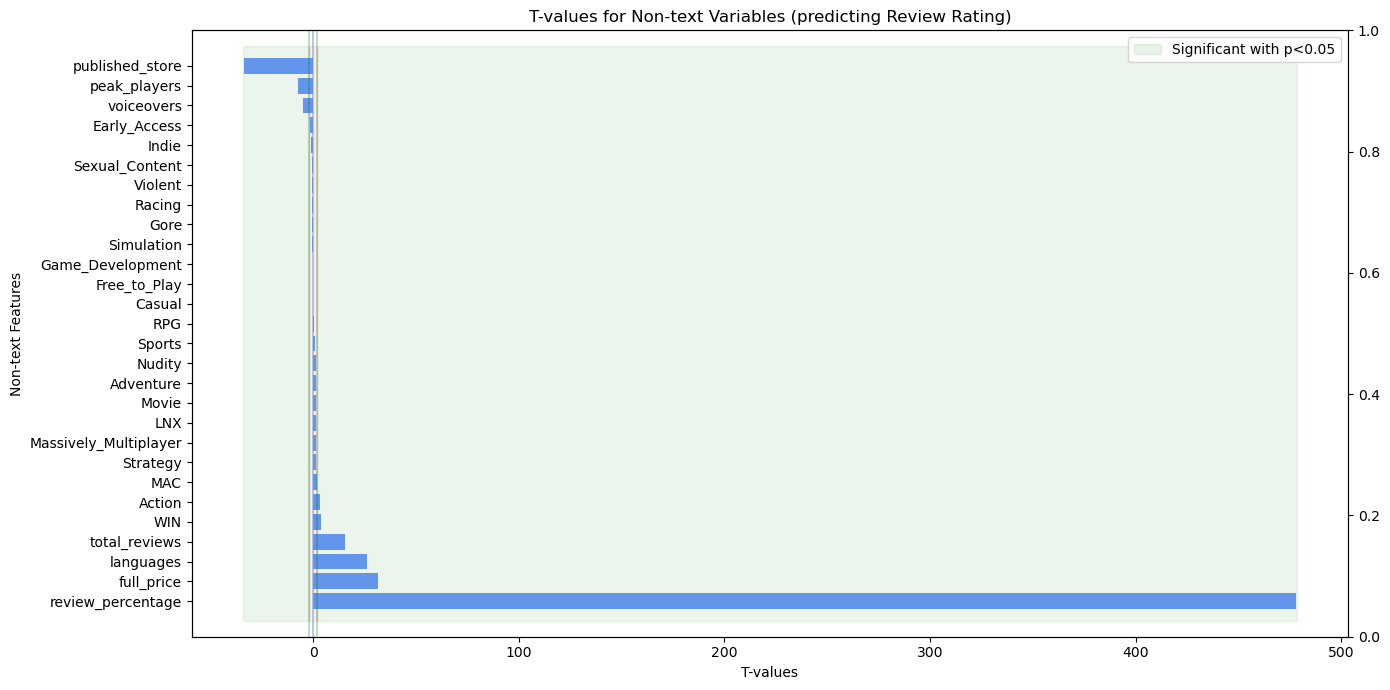

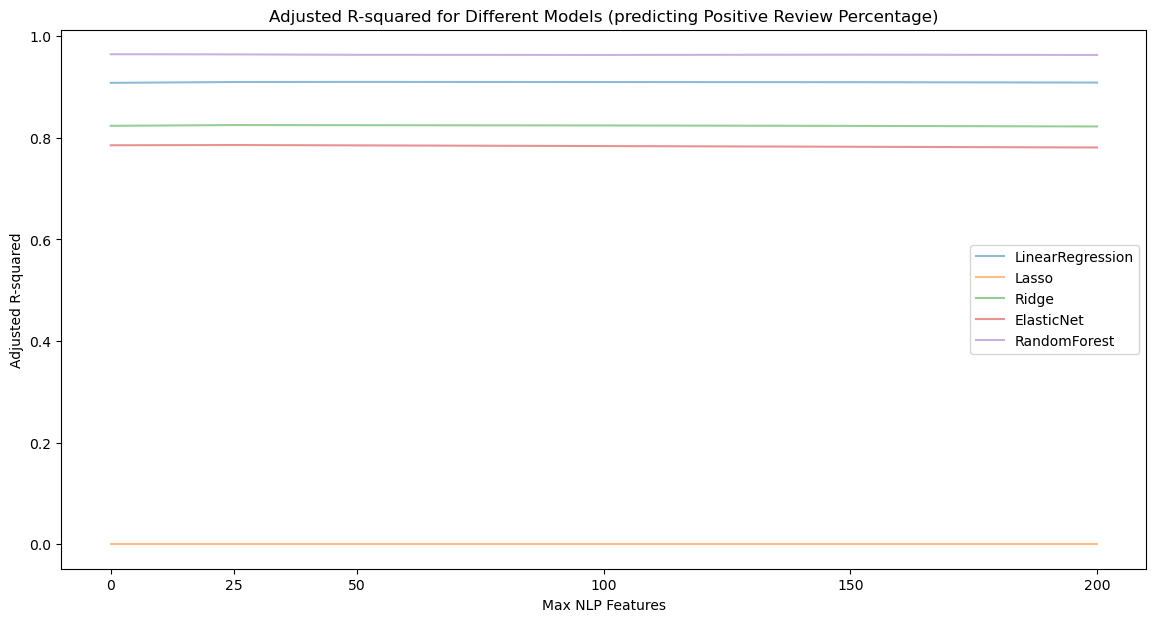

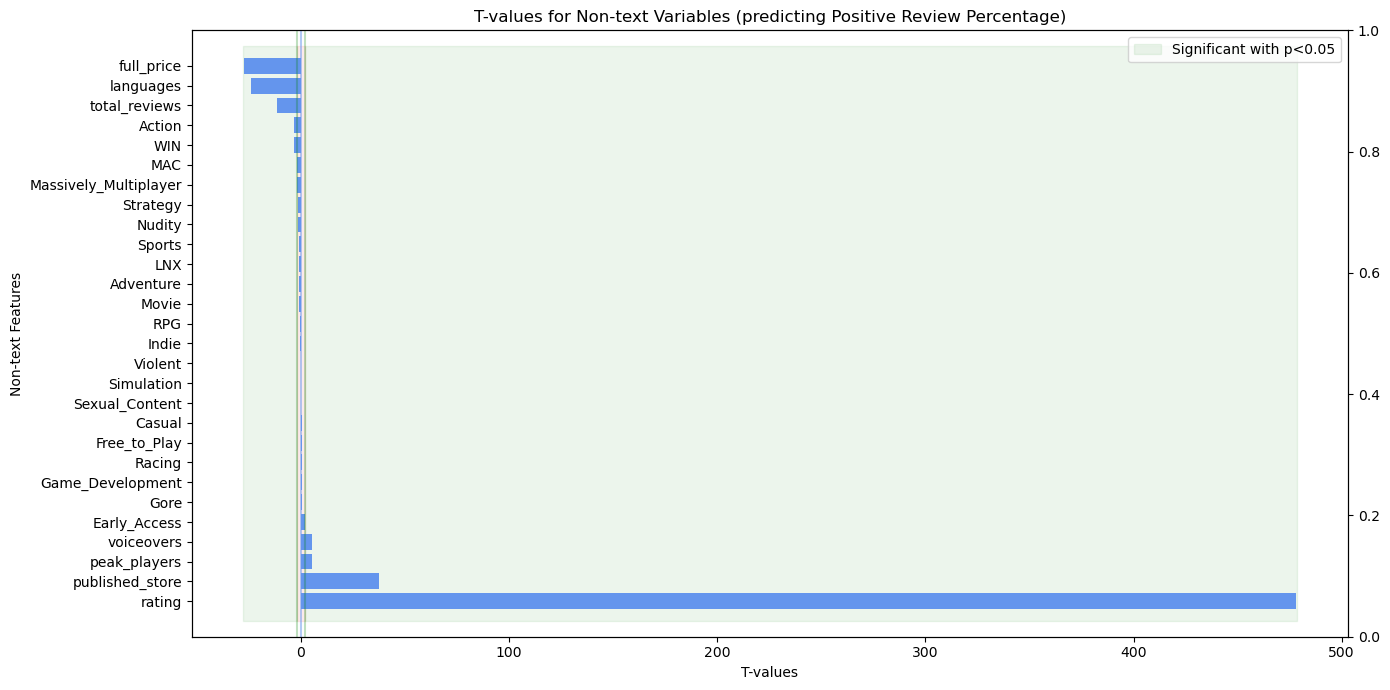

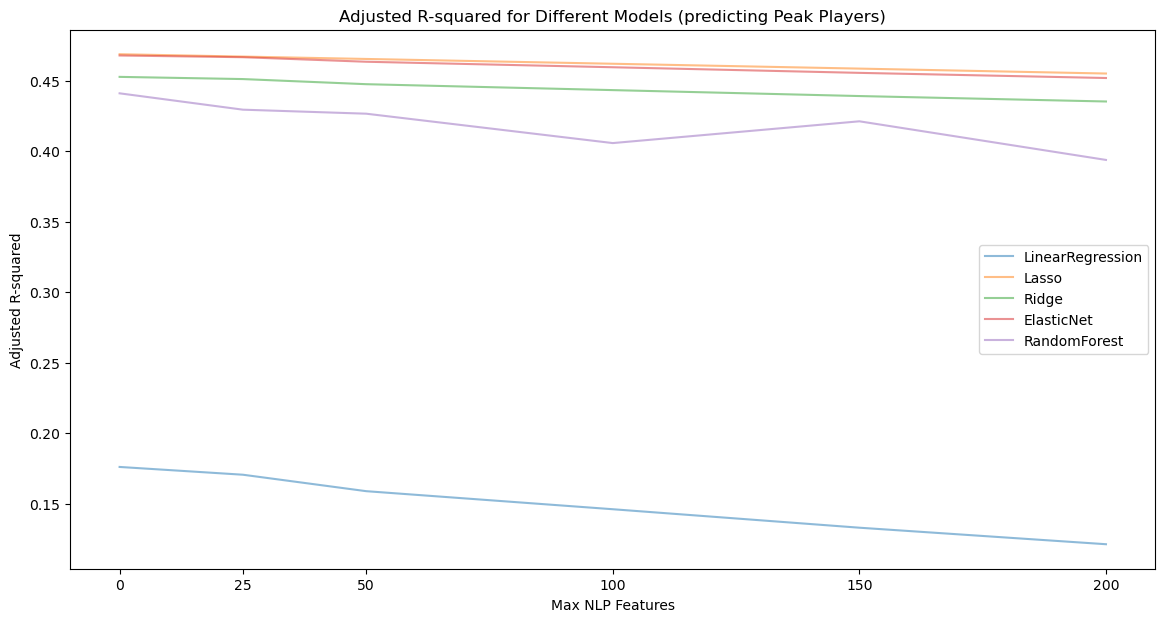

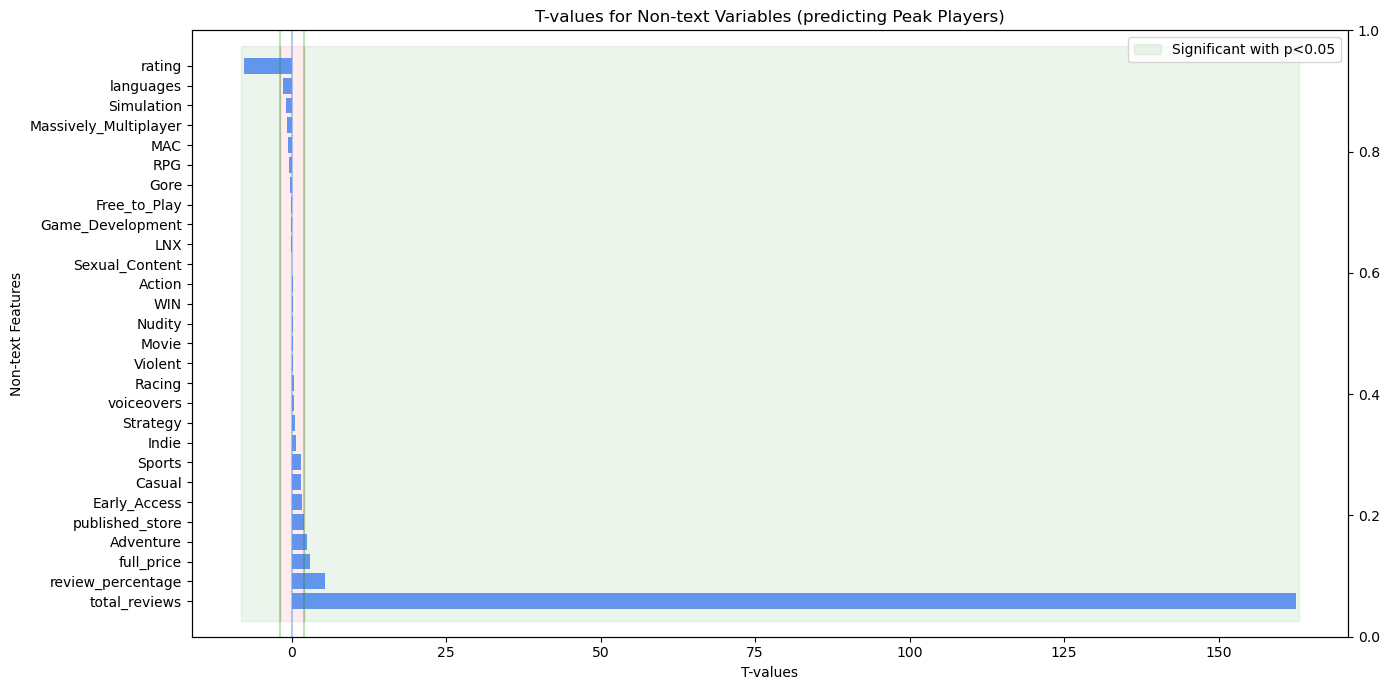

In [8]:
## Analyses including extended controls
        
NLP_owners_ext = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "igdb_popularity"], axis=1), 
                         "stsp_owners", "Owners",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_extended_controls")
results_owners_ext = NLP_owners_ext.analyze()

NLP_uscore_ext = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "stsp_owners", "igdb_popularity"], axis=1), 
                         "store_uscore", "User Score", 
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_extended_controls")
results_uscore_ext = NLP_uscore_ext.analyze()

NLP_reviews_ext = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "stsp_owners", "igdb_popularity"], axis=1), 
                         "total_reviews", "Total Reviews",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_extended_controls")
results_reviews_ext = NLP_reviews_ext.analyze()

NLP_reviewrating_ext = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "stsp_owners", "igdb_popularity"], axis=1), 
                         "rating", "Review Rating",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_extended_controls")
results_reviewrating_ext = NLP_reviewrating_ext.analyze()

NLP_reviewperc_ext = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "stsp_owners", "igdb_popularity"], axis=1), 
                         "review_percentage", "Positive Review Percentage",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_extended_controls")
results_reviewperc_ext = NLP_reviewperc_ext.analyze()

NLP_peak_ext = NLPAnalyzer(df.drop(["name", "hltb_single", "developers", "publishers", "categories", 
                                  "tags", "achievements", "gfq_rating", "description", 
                                  "store_uscore", "stsp_owners", "igdb_popularity"], axis=1), 
                         "peak_players", "Peak Players",
                         [0, 25, 50, 100, 150, 200],
                        naming_suffix="_extended_controls")
results_peak_ext = NLP_peak_ext.analyze()

## Step 5b: Plotting most influential words (using selected controls)

stsp_owners
_extended_controls
************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


store_uscore
_extended_controls
************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


total_reviews
_extended_controls
************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


rating
_extended_controls
************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


review_percentage
_extended_controls
************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


peak_players
_extended_controls
************************************************** 
 Using BOW Vectorizer 
 **************************************************
************************************************** 
 NLP: 50 words - Vectorization done 
 **************************************************


C:\Users\Tom\GitProjects\Predicting_Video_Game_Success\notebooks\analyses\analyses_tools.py:541: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_value = self.model_sm.tvalues[len(X_train_non_text.columns) + i + 1]


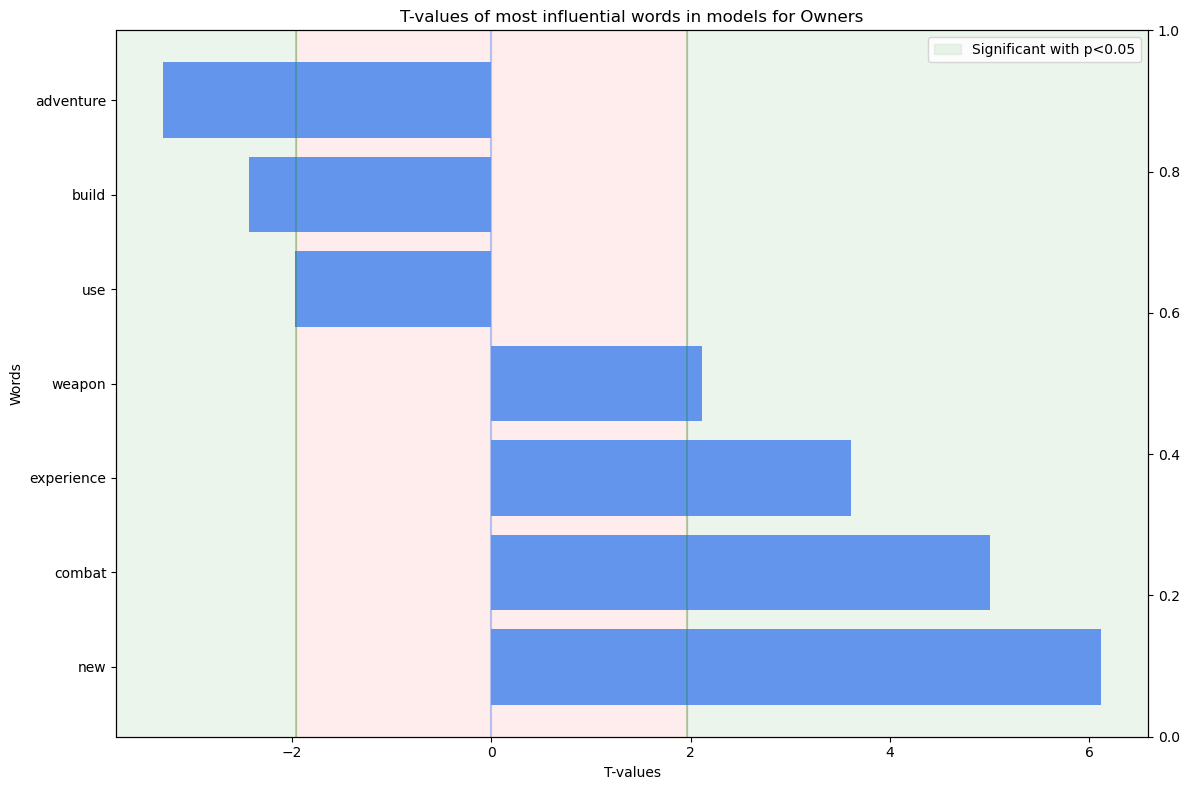

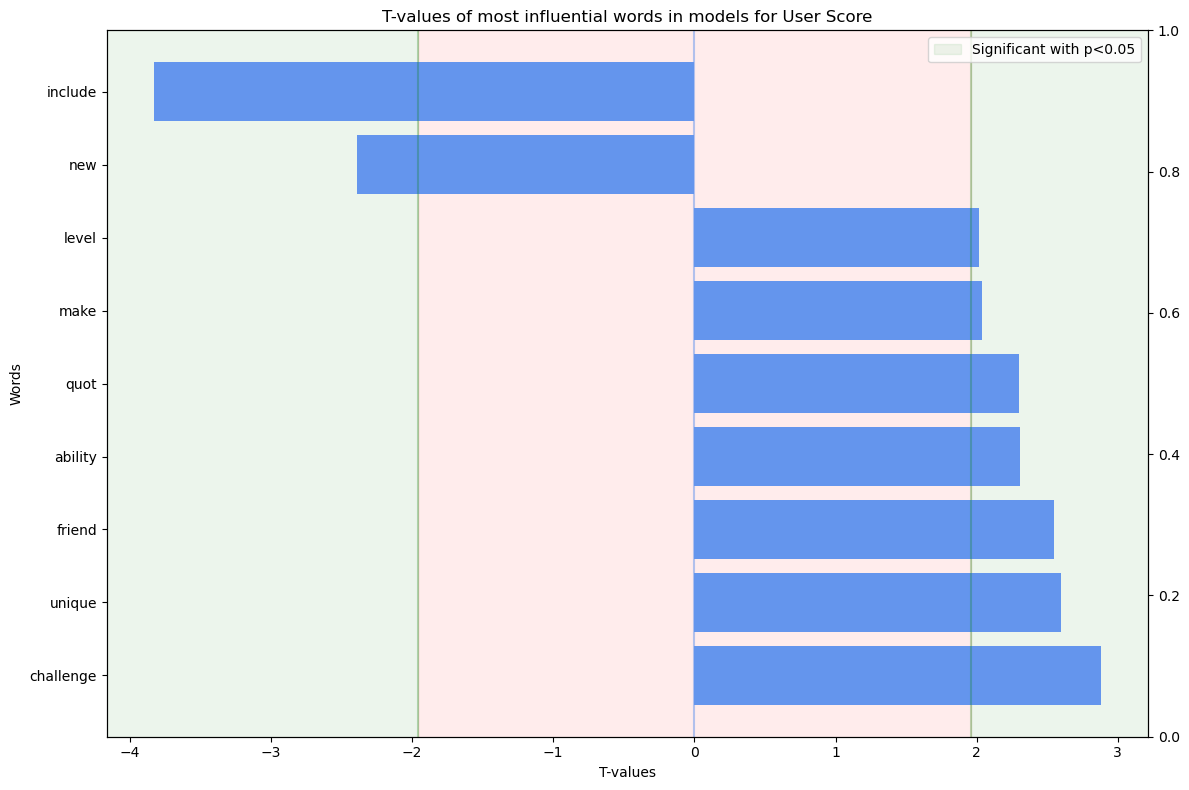

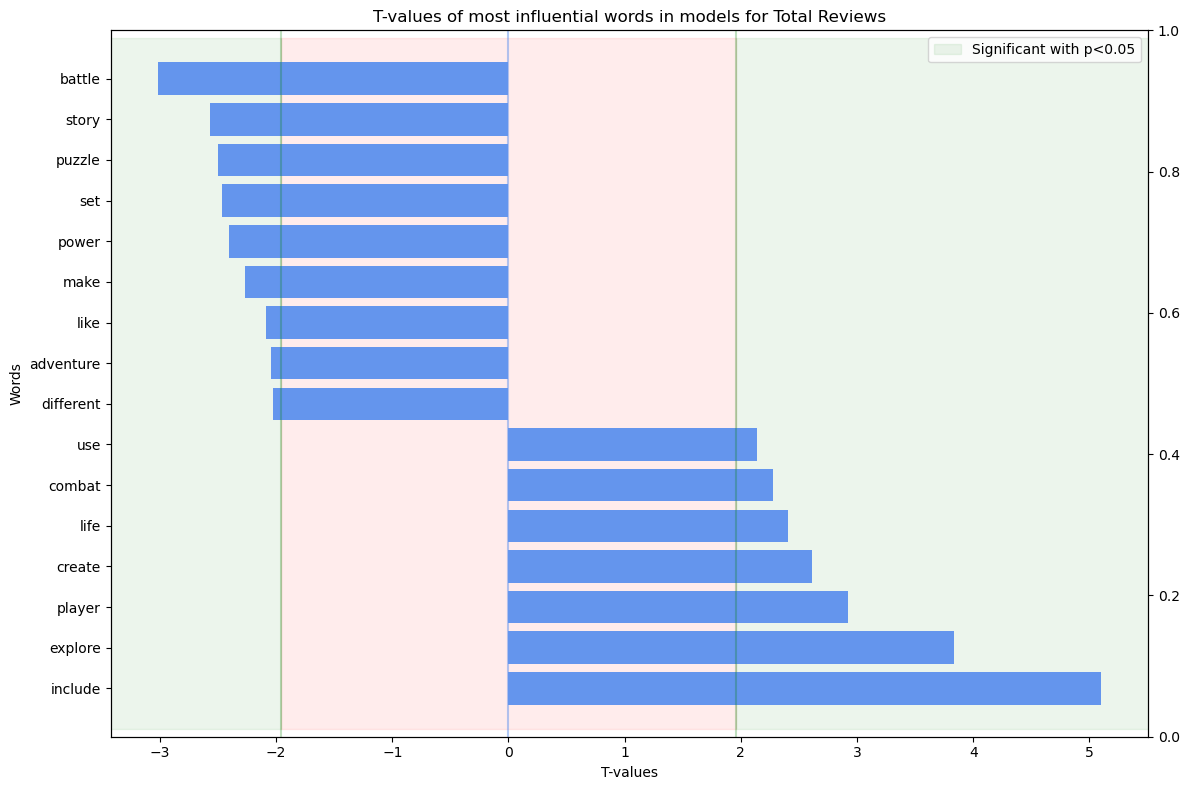

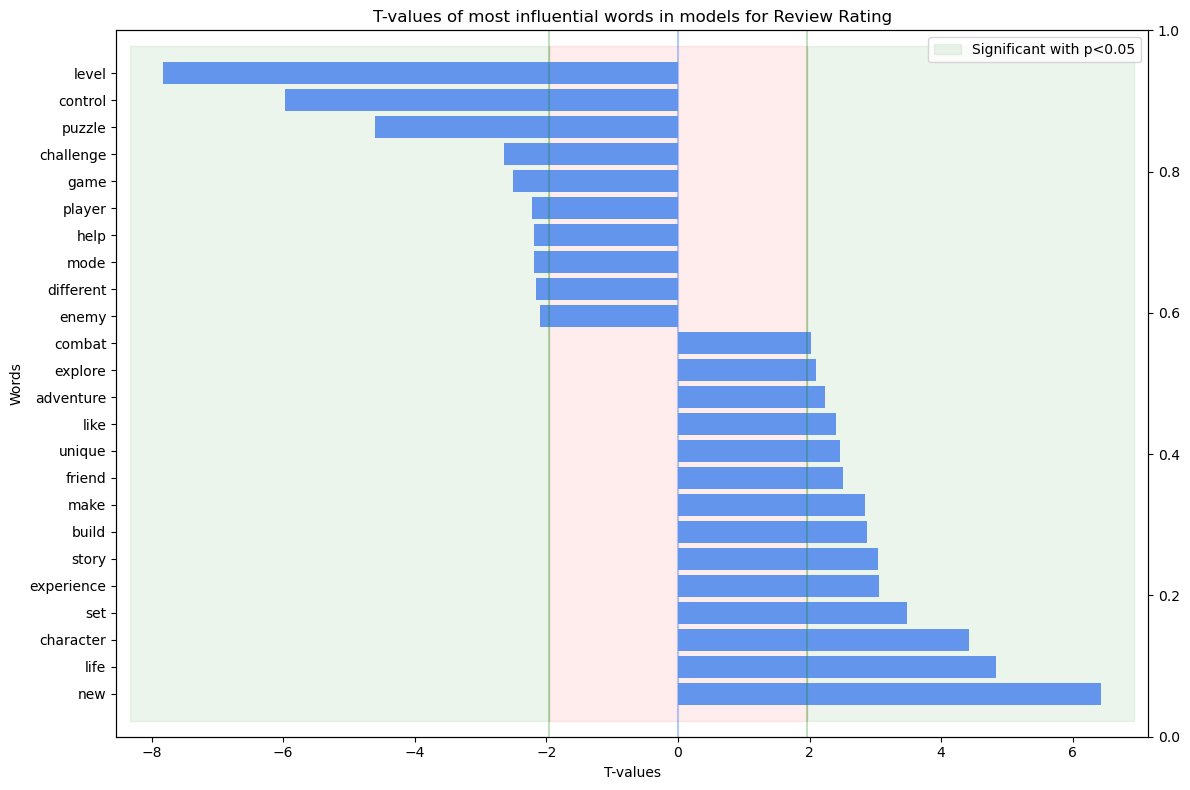

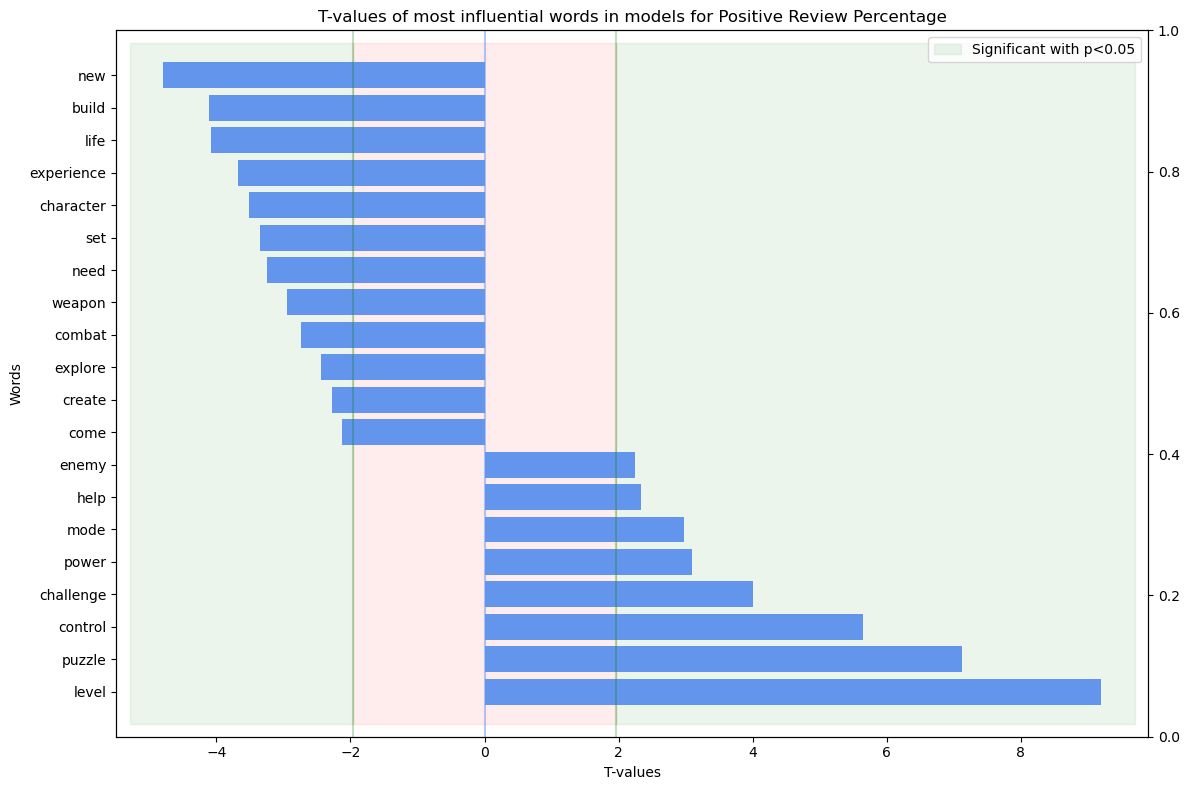

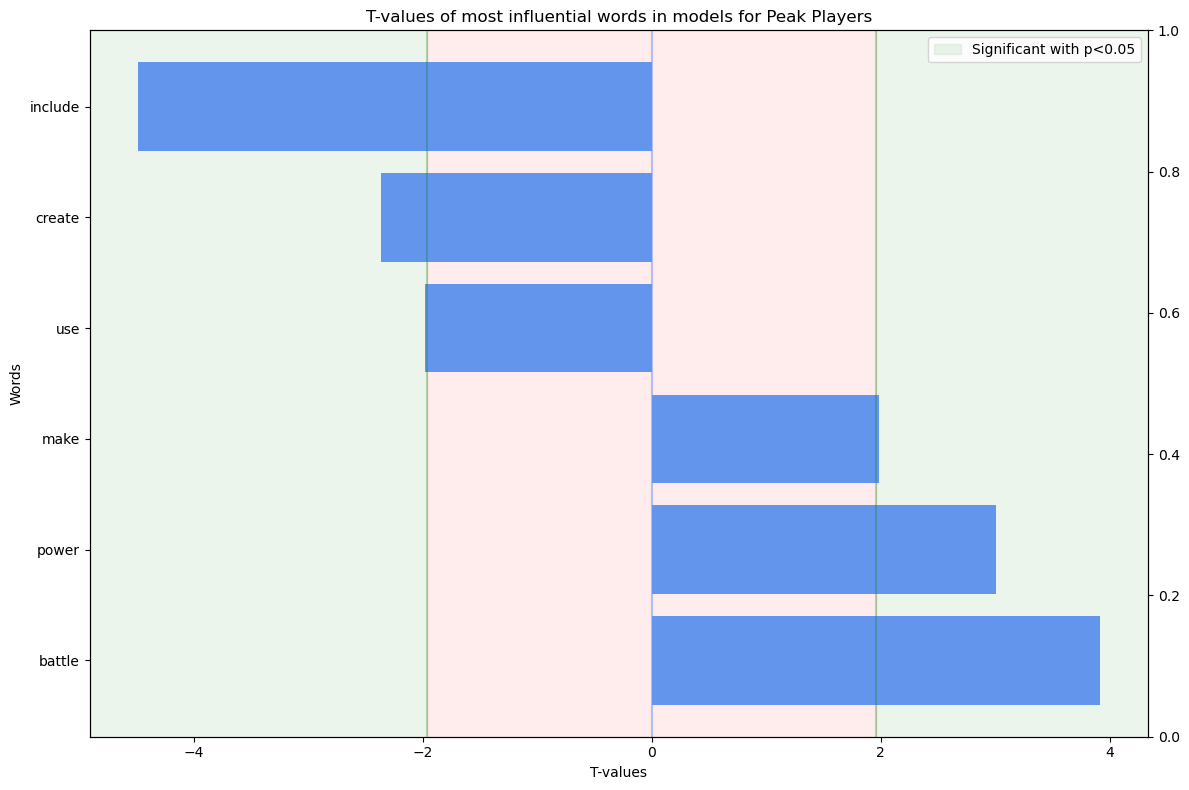

In [9]:
## Get all instances of NLPAnalyzer
nlp_instances = [value for name, value in globals().items() if name.startswith("NLP_") and name.endswith("_ext") and isinstance(value, NLPAnalyzer)]

## Plot words for all instances
for instance in nlp_instances:
    print(instance.target_var)
    print(instance.naming_suffix)
    instance.plot_words()
